In [ ]:
import json

with open('/kaggle/input/datano/diagnox.json' , 'r') as file:
    json_data = json.load(file)

In [ ]:
import pandas as p

data = p.DataFrame(json_data)
data

In [ ]:
data = data[(data['label'] == 'diagnosis') & (~data['code'].isin(['title', 'Regex']))]
data

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data[['label', 'description']], data.code, test_size=0.3, random_state=42)
print(x_train.ndim , x_test.ndim , y_train.ndim , y_test.ndim)
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

x_train_encoded = encoder.fit_transform(x_train).astype('float32')
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1 , 1)).astype('float32').toarray()

x_test_encoded = encoder.fit_transform(x_test).astype('float32')
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1 , 1)).astype('float32').toarray()
#
print(x_train_encoded.ndim , x_test_encoded.ndim , y_train_encoded.ndim , y_test_encoded.ndim)
print(x_train_encoded.shape , x_test_encoded.shape , y_train_encoded.shape , y_test_encoded.shape)

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

model = Sequential(
    [
        Dense(16 , input_dim=x_train_encoded.shape[1] , activation = 'relu'),
        Dense(32 , activation = 'relu') , 
        Dense(64 , activation = 'relu') , 
        Dense(128 , activation = 'relu') , 
        Dense(256, activation = 'relu') , 
        Dense(32 , activation = 'relu') , 
        Dense(512 , activation = 'relu') , 
        Dense(y_train_encoded.shape[1] , activation = 'softmax')
              
    ]
)

model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model with a smaller learning rate and categorical crossentropy loss
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Reduced learning rate
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']
)

In [ ]:
model.fit(
    x_train_encoded , 
    y_train_encoded , 
    epochs = 20 , 
    batch_size = 64
)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import json
# Load and prepare data
with open('/kaggle/input/datano/diagnox.json', 'r') as file:
    data = json.load(file)

In [ ]:
# Convert to DataFrame
df = pd.DataFrame(data)
df

In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['description'])
y = df['code']

print(X)
print(y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape , X_test.shape  ,y_train.shape , y_test.shape)

In [ ]:

# Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer  # Import from TensorFlow's Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
import pickle
import pandas as pd

# Load the dataset for mapping predictions to labels
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Define the max_length (must match training max_length)
max_length = 200

# Function to predict the code and label for new descriptions with confidence score
def predict_description_with_confidence(description, model, tokenizer, label_encoder):
    # Tokenize and pad the description
    sequence = tokenizer.texts_to_sequences([description])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=max_length)
    
    # Make the prediction
    prediction = model.predict(padded_sequence)
    predicted_code = np.argmax(prediction, axis=1)[0]
    confidence_score = prediction[0][predicted_code]
    
    # Map the code to the label
    predicted_code_str = label_encoder.inverse_transform([predicted_code])[0]
    predicted_label = data[data['code'] == predicted_code_str].iloc[0]['label']
    
    return {
        "description": description,
        "code": predicted_code_str,
        "label": predicted_label,
        "confidence": f"{confidence_score * 100:.2f}%"
    }

# Load tokenizer and label encoder
with open('/kaggle/input/model1/tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

with open('/kaggle/input/model1/label_encoder.pkl', 'rb') as f:
    loaded_label_encoder = pickle.load(f)

# Rebuild the model architecture
vocab_size = 5000
embedding_dim = 100
output_dim = len(loaded_label_encoder.classes_)

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(output_dim, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load the saved weights
model.load_weights('/kaggle/input/model1/diagnosis_model_advanced.h5')

# Example input description for prediction
new_description = "Type Diabetes Mellitus 1 complicated by "

# Make a prediction with confidence score
output = predict_description_with_confidence(new_description, model, loaded_tokenizer, loaded_label_encoder)

# Display the prediction with confidence score
print(output)


In [ ]:
!pip install keras 

In [ ]:
import numpy as np
import pandas as pd
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV

# Load the spaCy model for English
nlp = spacy.load('en_core_web_sm')

# Text Cleaning Function using spaCy
def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I)
    # Create a spaCy document object
    doc = nlp(text.lower())
    # Lemmatize and remove stop words
    words = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(words)

# Load dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Prepare inputs (X) and labels (y)
X = data['description'].values
y = data['code'].values

# Clean the text data
X_cleaned = [clean_text(desc) for desc in X]

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize text and limit vocabulary size
max_vocab_size = 5000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_cleaned)
X_tokenized = tokenizer.texts_to_sequences(X_cleaned)

# Padding sequences to fixed length
max_length = 200
X_padded = pad_sequences(X_tokenized, maxlen=max_length, padding='post')

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained word vectors (GloVe)
embedding_dim = 100  # You can choose 50, 100, 200, 300
embedding_index = {}
glove_file = f'glove.6B.{embedding_dim}d.txt'
with open(os.path.join('/kaggle/input/glove1/glove.6B', glove_file), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the model
def build_model(optimizer='adam', lstm_units=128, dropout_rate=0.5):
    model = Sequential([
        Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),  # Bidirectional LSTM
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),  # Additional Dense Layer
        Dropout(dropout_rate),
        Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
    ])
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter tuning with RandomizedSearchCV
# Instead of using KerasClassifier, we directly pass the model-building function to RandomizedSearchCV

def model_fn(optimizer='adam', lstm_units=128, dropout_rate=0.5):
    model = build_model(optimizer, lstm_units, dropout_rate)
    return model

param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7]
}
model = model_fn()  

# Now pass the model instance to RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=5, cv=3)
random_search.fit(X_train, y_train)
# Get the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Use the best model
best_model = random_search.best_estimator_

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, 
                         callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model and tokenizer
best_model.save('diagnosis_model_advanced.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Function to predict the code and label for new descriptions with confidence score
def predict_description_with_confidence(description, model, tokenizer, label_encoder):
    sequence = tokenizer.texts_to_sequences([description])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=max_length)
    prediction = model.predict(padded_sequence)
    predicted_code = np.argmax(prediction, axis=1)[0]
    confidence_score = prediction[0][predicted_code]
    predicted_code_str = label_encoder.inverse_transform([predicted_code])[0]
    predicted_label = data[data['code'] == predicted_code_str].iloc[0]['label']
    
    return {
        "description": description,
        "code": predicted_code_str,
        "label": predicted_label,
        "confidence": f"{confidence_score * 100:.2f}%"
    }

# Example input description for prediction
new_description = "Secondary carcinoid tumors of bone"

# Load the trained model and tokenizer for prediction
loaded_model = load_model('diagnosis_model_advanced.h5')
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_encoder = pickle.load(f)

# Make a prediction with confidence score
output = predict_description_with_confidence(new_description, loaded_model, loaded_tokenizer, loaded_label_encoder)
print(output)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D, Conv1D, MaxPooling1D  , Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import regularizers
import json
import os
import pickle

# Load dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Prepare inputs (X) and labels (y)
X = data['description'].values
y = data['code'].values

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize text and limit vocabulary size
max_vocab_size = 5000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)

max_length = 200
X_padded = pad_sequences(X_tokenized, maxlen=max_length, padding='post')

X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained word vectors (e.g., GloVe)
embedding_dim = 300  # Increased embedding dimension for more parameters
embedding_index = {}
glove_file = f'glove.6B.{embedding_dim}d.txt'
with open(os.path.join('/kaggle/input/glove1/glove.6B', glove_file), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define the model
vocab_size = max_vocab_size
output_dim = len(label_encoder.classes_)


# Increased model size with larger LSTM layers, Dense layers, and Conv1D
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_length)(input_layer)

# Increase the units and layers to scale the parameters
conv_layer = Conv1D(2048, 5, activation='relu')(embedding_layer)
maxpool_layer = MaxPooling1D(pool_size=4)(conv_layer)

# Increased number of LSTM units
lstm_layer = Bidirectional(LSTM(8192, return_sequences=True))(maxpool_layer)  # LSTM with 8192 units

global_max_pool = GlobalMaxPooling1D()(lstm_layer)
dense_layer = Dense(8192, activation='relu')(global_max_pool)  # Dense with 8192 units
dropout_layer = Dropout(0.6)(dense_layer)

# Final output layer with softmax activation for classification
output_layer = Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()
    

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Example dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')
# Apply text cleaning to descriptions
data['description'] = data['description'].apply(clean_text)

# Prepare training data
descriptions = data['description'].tolist()
labels = data['label'].tolist()
codes = data['code'].tolist()

# Split dataset into train and test
X_train, X_test, y_train_labels, y_test_labels = train_test_split(descriptions, labels, test_size=0.2, random_state=42)
_, _, y_train_codes, y_test_codes = train_test_split(descriptions, codes, test_size=0.2, random_state=42)

# Combine labels and codes into a single target variable for multi-output classification
y_train = list(zip(y_train_labels, y_train_codes))
y_test = list(zip(y_test_labels, y_test_codes))

# Create a model pipeline: TF-IDF + MultiOutput Logistic Regression
vectorizer = TfidfVectorizer()
model = make_pipeline(vectorizer, MultiOutputClassifier(LogisticRegression(max_iter=1000)))

# Train the model
model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Testing the trained model on some example unstructured data
unstructured_data = "patient has Diabetes and disorder"
unstructured_data_clean = clean_text(unstructured_data)
predicted_label, predicted_code = model.predict([unstructured_data_clean])[0]
print(f"Predicted Label: {predicted_label}, Predicted Code: {predicted_code}")


In [ ]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Orthogonal
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Define custom objects
custom_objects = {
    'Orthogonal': Orthogonal
}

# Load your model with custom objects
try:
    loaded_model = load_model('/kaggle/input/model1/diagnosis_model_advanced.h5', custom_objects=custom_objects)
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)

# Load tokenizer and label encoder
try:
    with open('/kaggle/input/final-model/tokenizer.pkl', 'rb') as f:
        loaded_tokenizer = pickle.load(f)
    with open('/kaggle/input/final-model/label_encoder.pkl', 'rb') as f:
        loaded_label_encoder = pickle.load(f)
    print("Tokenizer and label encoder loaded successfully!")
except Exception as e:
    print("Error loading tokenizer/label encoder:", e)

# Load the JSON data (descriptions)
try:
    with open('/kaggle/input/datano/diagnox.json', 'r') as f:
        descriptions_data = json.load(f)
    print("Descriptions data loaded successfully!")
except Exception as e:
    print("Error loading descriptions data:", e)

# Extract the descriptions from the JSON data for comparison
descriptions = [item['description'] for item in descriptions_data]

def find_best_matching_description(unstructured_text, descriptions):
    # Use bigrams in the vectorizer for better semantic capture
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=5000)
    all_texts = [unstructured_text] + descriptions
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    # Print cosine similarities to debug
    print("Cosine Similarities:", cosine_similarities)

    most_similar_index = np.argmax(cosine_similarities)
    return descriptions[most_similar_index], descriptions_data[most_similar_index]

def predict_description_with_confidence(description, model, tokenizer, label_encoder, max_length=100):
    sequence = tokenizer.texts_to_sequences([description])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=max_length)
    prediction = model.predict(padded_sequence)
    predicted_code = np.argmax(prediction, axis=1)[0]
    confidence_score = prediction[0][predicted_code]
    predicted_code_str = label_encoder.inverse_transform([predicted_code])[0]
    predicted_label = next(item['label'] for item in descriptions_data if item['code'] == predicted_code_str)
    return {
        "description": description,
        "code": predicted_code_str,
        "label": predicted_label,
        "confidence": f"{confidence_score * 100:.2f}%"
    }

def predict_from_unstructured_text(unstructured_text, model, tokenizer, label_encoder, descriptions_data):
    best_match_description, best_match_metadata = find_best_matching_description(unstructured_text, descriptions)
    result = predict_description_with_confidence(best_match_description, model, tokenizer, label_encoder)
    return result

#  Example unstructured text
unstructured_text = """
   patient states her symptoms are lymph node swelling and tongue swelling that started in september.
"""

# Make the prediction
try:
    output = predict_from_unstructured_text(unstructured_text, loaded_model, loaded_tokenizer, loaded_label_encoder, descriptions_data)
    print("Prediction:", output)
except Exception as e:
    print("Error during prediction:", e)


print("Unstructured Text:\n", unstructured_text)
print("\nFirst 5 Descriptions:\n", descriptions[:5])

print("Tokenized Unstructured Text:", loaded_tokenizer.texts_to_sequences([unstructured_text]))



In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # We take the embeddings from the last hidden state
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Get embeddings for unstructured text and descriptions
unstructured_text_embedding = get_bert_embeddings(unstructured_text)
descriptions_embeddings = [get_bert_embeddings(desc) for desc in descriptions]

# Calculate cosine similarity between unstructured text and descriptions embeddings
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity([unstructured_text_embedding], descriptions_embeddings).flatten()

# Find the best match based on cosine similarity
most_similar_index = np.argmax(cosine_similarities)
best_match_description = descriptions[most_similar_index]
print(f"Best matching description: {best_match_description}")


In [ ]:
import pandas as pd


data = pd.read_json('/kaggle/input/datano/diagnox.json')

print(data.head())

In [ ]:
y = data.description[18816 : ]
x = data['description'][ : 43904]

print(y)

In [ ]:
# Step 3: Ensure x and y have the same length
if len(x) != len(y):
    print("Warning: x and y have different lengths! Adjusting...")
    # Adjusting y to match x's length by slicing (you can also truncate x or y as needed)
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]

In [ ]:
from sklearn.model_selection import train_test_split
# Step 4: Split into train and test sets (optional but recommended)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.ndim , x_test.ndim , y_train.ndim , y_test.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Reduce the number of features for TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression


# Use a more appropriate solver for large data or sparse data
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Train the model
model.fit(x_train_tfidf, y_train)

In [ ]:
input = """
patient name patricia stith date birth 08281947 dysphagia oropharyngeal phase ph 8593401377 past medical history condition answer notes heart attack mi cancer colon hypertension history present illness note 76yo tongue swelling given cephalexin 91423 completed given chlorhexidine mouth wash doxycycline methylprednisone triamcinolone paste thursday started wanted wait see ent said patient states symptoms lymph node swelling tongue swelling started september caused problems talking swallowing unable wear dentures states seen er told couldnt determine cause released former smoker stopped smoking 2016 history colon cancer colectomy husband states past couple months black blood stool odorous since stopped without review systems brief otolaryngology ros reported patient constitutional sweats weight gain unintended weight loss intolerance eyes eyes eyes change ears hearing pain pressure discharge nose nosebleeds congestion pressure obstruction enmt nasal drip mouththroat throat gums mouth abnormalities ulcers abnormalities breathing taste tonsils change difficulty swallowing cardiovascular pain pain exertion breath cardiovascular walking breath lying breath awakens sleep heart murmur extremity swelling respiratory breath rest shortness breath exertion apnea production gastrointestinal pain normal appetite black tarry stools stools swelling neurologic consciousness dizziness headaches disturbances legs normal gait psychiatric psych difficulties concentrating hematologiclymphatic glands bruising hematologiclymphatic problems allergyimmunologic nose pressure allergicimmunologic physical exam ent exam general appearance healthyappearing wellnourished well groomed distress constitutional communication normal communication wo aids normal voice quality inspection atraumatic facial strength normal strength normal symmetry tic sinuses salivary headface glands parotid glands masses submandibular glands masses inspection tmj symmetric opening motion palpation tmj nontender eyes pupils eom intact perrla conjunctiva noninjected right hearing rinne acbc weber midline left hearing rinne acbc weber midline right external ear normally formed free lesions left external ear normally formed free lesions right external auditory canal normal appearance erythema left external auditory canal normal appearance right tympanic membrane mobile pneumatic otoscopy pearly grey landmarks clear left tympanic membrane mobile pneumatic otoscopy pearly grey landmarks clear nasal skin nasal dorsum symmetric palpable deformities nasal tip normal symmetric nasal tip normal nasal valves nasal page 7 8
"""
input = [[input]]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Example input data (your provided input)
input_text = """
patient name patricia stith date birth 08281947 dysphagia oropharyngeal phase ph 8593401377 ...
"""

# Create a TF-IDF vectorizer instance
vectorizer = TfidfVectorizer()

# Convert the input data into a numerical format (vector)
input_vectorized = vectorizer.fit_transform([input_text])

# Now input_vectorized is in numerical format and can be passed into the model
y_pred = model.predict(input_vectorized)


In [ ]:
print(y_pred)

In [ ]:
model.score(x_test_tfidf , y_test *100)

print(model.score(x_train_tfidf , y_train *100))

In [ ]:
import json
import pdfplumber
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        return " ".join([page.extract_text() for page in pdf.pages])

def match_and_predict(text, data, model=None, vectorizer=None):
    # Match with JSON data
    text_lower = text.lower()
    matches = [entry for entry in data if text_lower in entry["description"].lower()]

    if matches:
        return matches
    elif model and vectorizer:
        # Predict using ML model
        vectorized_text = vectorizer.transform([text])
        prediction = model.predict(vectorized_text)
        return [{"code": None, "label": "predicted", "description": prediction[0]}]
    else:
        return []

# Load data and train model
def train_model(data):
    descriptions = [entry['description'] for entry in data]
    labels = [entry['code'] for entry in data]
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(descriptions)
    model = LogisticRegression()
    model.fit(X, labels)
    return model, vectorizer

# Main workflow
pdf_path = "/kaggle/input/pdf-data/401152946.pdf"
data_file_path = "/kaggle/input/datano/diagnox.json"
with open(data_file_path, 'r') as file:
    data = json.load(file)

# Train model
model, vectorizer = train_model(data)

# Analyze PDF
report_text = extract_text_from_pdf(pdf_path)
results = match_and_predict(report_text, data, model, vectorizer)

# Display results
for result in results:
    print(f"Code: {result['code']}, Label: {result['label']}, Description: {result['description']}")


In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to process the text and clean it
def process_text(text):
    # Process the text using spaCy
    doc = nlp(text)
    
    # Remove stopwords, punctuation, and apply lemmatization
    cleaned_tokens = []
    for token in doc:
        # Remove stopwords and punctuation, and lemmatize
        if not token.is_stop and not token.is_punct:
            # Ensure the lemma is a string and add it to the list
            lemma = str(token.lemma_)  # Use token.lemma_ which is always a string
            cleaned_tokens.append(lemma)  # Add lemmatized token as a string
    
    # Join the cleaned tokens back into a single string
    return " ".join(cleaned_tokens)

# Read text from the file
with open('/kaggle/input/text-1/demotxt.txt', 'r') as file:
    text = file.read()

# Process the text
cleaned_text = process_text(text)

# Save the cleaned text to another file
with open('cleaned_output.txt', 'w') as file:
    file.write(cleaned_text)

# Optionally print cleaned text
print("Original Text: \n", text[:])  # Print first 500 characters of original text
print("\nCleaned Text: \n", cleaned_text[:500])  # Print first 500 characters of cleaned text


In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to process the text and clean it with more detailed steps
def process_text(text):
    # Process the text using spaCy
    doc = nlp(text)
    
    # Remove stopwords, punctuation, non-alphabetic tokens, and apply lemmatization
    cleaned_tokens = []
    for token in doc:
        # Remove stopwords, punctuation, and non-alphabetic tokens
        if not token.is_stop and not token.is_punct and token.is_alpha:
            # Ensure the lemma is a string and add it to the list
            lemma = str(token.lemma_)  # Use token.lemma_ which is always a string
            cleaned_tokens.append(lemma)  # Add lemmatized token as a string
    
    # Join the cleaned tokens back into a single string
    cleaned_text = " ".join(cleaned_tokens)
    
    # Remove any leading or trailing whitespaces
    cleaned_text = cleaned_text.strip()
    
    return cleaned_text

# Read text from the file
with open('/kaggle/input/text-1/demotxt.txt', 'r') as file:
    text = file.read()

# Process the text
cleaned_text = process_text(text)

# Save the cleaned text to another file
with open('cleaned_output.txt', 'w') as file:
    file.write(cleaned_text)

# Optionally print cleaned text (first 500 characters)
print("\nCleaned Text: \n", cleaned_text[:])  # Print first 500 characters of cleaned text


In [ ]:
import re

def clean_clinical_data(text):
    # Step 1: Remove addresses (general street and location patterns)
    text = re.sub(r'\d{1,5}\s[A-Za-z\s]+(?:Street|Road|Drive|Ave|Boulevard|St|Suite|Lane|Court)', '', text)

    # Step 2: Remove phone numbers (formats like (123) 456-7890, 123-456-7890, etc.)
    text = re.sub(r'\(?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}', '', text)

    # Step 3: Remove specific phrases like "hospital lab registration" and other location-based phrases
    text = re.sub(r'\b(?:hospital lab registration|bourbon community|linville dr paris|lexington rd georgetown ky)\b', '', text)

    # Step 4: Remove metadata-like content such as document, file, record, etc.
    text = re.sub(r'\b(?:document|file|record|referral|registration|note|procedure)\b[^\n]*\n', '', text)

    # Step 5: Remove personal info like names, DOB, SSN, etc.
    # Regex to remove patient information such as name, DOB, SSN, and other personal identifiers
    text = re.sub(r'\b(?:patient|contact|social security number|phone|dob|name|address)\b[^\n]*\n?', '', text, flags=re.DOTALL)

    # Step 6: Clean extra spaces, multiple spaces, and newlines
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Sample raw text (abbreviated version for debugging)
raw_text = """
patient patricia stith date birth coordinator healthplans encounter summary patricia stith electronically sign leslie asbury md social security number xxx encounter oid service event encounter participant leslie ann asbury contact linville drive suite e paris ky ph legal authenticator leslie asbury md electronically sign contact lexington rd georgetown ky ph table content reason visit chief complaint assessment plan treatment medication medication administer vital sign result problem procedure 
"""

# Apply the cleaning function to the raw text
cleaned_text = clean_clinical_data(raw_text)

# Print the cleaned text (first 500 characters)
print("Final Cleaned Text Preview (First 500 chars):")
print(cleaned_text[:500])  # This should print the first 500 characters of cleaned text


In [ ]:
import nltk
import re
import string
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalMaxPooling1D , SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f'{len(physical_devices)} GPU(s) available: {physical_devices}')
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print('No GPU available, using CPU.')

# Load dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Preprocess the text to ensure it is a string
def preprocess_text(text):
    text = str(text)  # Convert to string
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply preprocessing to the descriptions
data['description'] = data['description'].apply(preprocess_text)

# Prepare inputs (X) and labels (y)
X = data['description'].values
y = data['code'].values

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize text and limit vocabulary size
max_vocab_size = 5000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X)
X_tokenized = tokenizer.texts_to_sequences(X)
max_length = 200
X_padded = pad_sequences(X_tokenized, maxlen=max_length, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained word vectors (e.g., GloVe)
embedding_dim = 100  # You can choose 50, 100, 200, 300
embedding_index = {}
glove_file = f'glove.6B.{embedding_dim}d.txt'
with open(os.path.join('/kaggle/input/glove1/glove.6B', glove_file), encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Prepare embedding matrix
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Use distributed strategy
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    vocab_size = max_vocab_size
    output_dim = len(label_encoder.classes_)
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(max_length,), weights=[embedding_matrix], trainable=False),
        Bidirectional(SimpleRNN(512, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(output_dim, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

model.save('diagnosis_model_advanced.h5')
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Function to predict the code and label for new descriptions with confidence score
def predict_description_with_confidence(description, model, tokenizer, label_encoder):
    # Tokenize and pad the description
    sequence = tokenizer.texts_to_sequences([description])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=max_length)
    # Make the prediction
    prediction = model.predict(padded_sequence)
    predicted_code = np.argmax(prediction, axis=1)[0]
    confidence_score = prediction[0][predicted_code]
    # Map the code to the label
    predicted_code_str = label_encoder.inverse_transform([predicted_code])[0]
    predicted_label = data[data['code'] == predicted_code_str].iloc[0]['label']
    return {
        "description": description,
        "code": predicted_code_str,
        "label": predicted_label,
        "confidence": f"{confidence_score * 100:.2f}"
    }

# Example input description for prediction
new_description = "Secondary carcinoid tumors of bone"

# Load the trained model and tokenizer
loaded_model = load_model('diagnosis_model_advanced.h5')
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_encoder = pickle.load(f)

# Make a prediction with confidence score
output = predict_description_with_confidence(new_description, loaded_model, loaded_tokenizer, loaded_label_encoder)

# Display the prediction with confidence score
print(output)


In [ ]:
import jeeva
import requests
from bs4 import BeautifulSoup
from googlesearch import search
import spacy

# Initialize spaCy
nlp = spacy.load("en_core_web_sm")

# Perform a Google search
query = "Python programming"
for url in search(query, num_results=5):
    print(f"Found URL: {url}")

    # Fetch the URL content
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Extract text from the webpage
    text = soup.get_text()

    # Use spaCy to analyze the text
    doc = nlp(text)
    for sent in doc.sents:
        print(sent.text)


In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


with open('/kaggle/input/datano/diagnox.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)


df['combined_label'] = df['label'] + '-' + df['code']


df['description'] = df['description'].str.lower()


label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['combined_label'])


X_train, X_test, y_train, y_test = train_test_split(df['description'], df['encoded_label'], test_size=0.2, random_state=42)


print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)

print(X_train.ndim , X_test.ndim , y_train.ndim , y_test.ndim)

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class CustomDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer, max_length):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        text = self.descriptions.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


MAX_LENGTH = 128
BATCH_SIZE = 16


train_dataset = CustomDataset(X_train, y_train, tokenizer, MAX_LENGTH)
test_dataset = CustomDataset(X_test, y_test, tokenizer, MAX_LENGTH)


model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['combined_label'].unique()))


def compute_metrics(p):
    predictions, labels = p
    predictions = torch.tensor(predictions) if not isinstance(predictions, torch.Tensor) else predictions
    labels = torch.tensor(labels) if not isinstance(labels, torch.Tensor) else labels
    
    # Get the index of the highest logit (predicted class)
    predictions = torch.argmax(predictions, dim=-1)
    
    # Calculate accuracy
    return {"eval_accuracy": accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())}


# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy", 
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  
)


trainer.train()


eval_result = trainer.evaluate()
print(f"Test Accuracy: {eval_result['eval_accuracy']:.2f}")

In [ ]:
def predict_description(description):
    # Ensure the model is on the correct device (CPU or GPU)
    device = model.device  # Check the device where the model is located
    
    encoding = tokenizer.encode_plus(
        description,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    ).to(device)  # Move the input tensors to the same device as the model
    
    # Forward pass through the model
    output = model(**encoding)
    
    # Get the predicted label id
    predicted_label_id = output.logits.argmax(dim=1).item()
    
    # Decode the predicted label id back to the label string
    predicted_label = label_encoder.inverse_transform([predicted_label_id])
    return predicted_label[0]

# Example usage:
new_description =   "Acute coccidioidomycosis"
predicted_label = predict_description(new_description)
print(f"Predicted Label-Code: {predicted_label}")


In [ ]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score

# Load data
with open('/kaggle/input/datano/diagnox.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)

# Combine label and code for unique class identification
df['combined_label'] = df['label'] + '-' + df['code']

# Preprocess descriptions
df['description'] = df['description'].str.lower()

# Label encode combined label
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['combined_label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['encoded_label'], test_size=0.2, random_state=42)

# Check the shapes of the data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Tokenizer and Dataset class
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create Dataset class
class CustomDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer, max_length, device):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        text = self.descriptions.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move tensors to the correct device (GPU or CPU)
        input_ids = encoding['input_ids'].flatten().to(self.device)
        attention_mask = encoding['attention_mask'].flatten().to(self.device)
        label_tensor = torch.tensor(label, dtype=torch.long).to(self.device)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label_tensor
        }

# Define constants
MAX_LENGTH = 256  # Increased max length
BATCH_SIZE = 32  # Larger batch size for potentially better results

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create datasets
train_dataset = CustomDataset(X_train, y_train, tokenizer, MAX_LENGTH, device)
test_dataset = CustomDataset(X_test, y_test, tokenizer, MAX_LENGTH, device)

# Load pre-trained BERT model and move it to GPU
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['combined_label'].unique()))
model.to(device)

# Compute metrics function
def compute_metrics(p):
    predictions, labels = p

    # Ensure that predictions and labels are both PyTorch tensors on the same device
    predictions = torch.tensor(predictions).to(device) if not isinstance(predictions, torch.Tensor) else predictions.to(device)
    labels = torch.tensor(labels).to(device) if not isinstance(labels, torch.Tensor) else labels.to(device)

    # Get the index of the highest logit (predicted class)
    predictions = torch.argmax(predictions, dim=-1)

    # Calculate accuracy
    return {"eval_accuracy": accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())}

# Training arguments with tuned hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy", 
    learning_rate=2e-5,  # Learning rate tuned
)

# Initialize the Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # Early stopping callback
)

# Train the model
trainer.train()

# Evaluate the model
eval_result = trainer.evaluate()
print(f"Test Accuracy: {eval_result['eval_accuracy']:.2f}")


In [ ]:

from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

# Load the tokenizer and model for medical NER (Named Entity Recognition)
tokenizer = AutoTokenizer.from_pretrained("AdaptLLM/medicine-LLM")
model = AutoModelForTokenClassification.from_pretrained("AdaptLLM/medicine-LLM")

# Sample unstructured medical text
text = """
patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. 
turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. 
oral mucosa: normal, moist, . palate: normal hard palate, normal soft palate. tongue: normal tongue, lesions, . tonsils: normal tonsils, . 
posterior pharynx: normal. cavity/mouth: hypopharynx: normal hypopharynx, normal tongue base, normal pyriform sinus. larynx: normal epiglottis, 
normal false vocal cords, normal true vocal cords, normal glottic mobility. nasopharynx: normal, normal adenoids, normal eustachian tubes, choanae patent 
neck: symmetrical, trachea midline. thyroid: symmetric, , , neck:  inspection/auscultation: good air movement, chest expands symmetrically, clear bilaterally, 
respiratory: normal breath sounds, , /crackles, ,  cardiovascular auscultation: regular rate and rhythm, , , . observation/palpation of peripheral vascular system: , 
carotid pulse normal, system:  cervical:  lymph node enlargement,  adenopathy,  lymph nodes: cervical adenopathy,  cervical adenopathy,  adenopathy. axillary:  
lymph node enlargement orientation: oriented to time, oriented to place, oriented to person. mood and affect: normal mood, normal affect. cranial nerves: cranial nerves 
ii-xii intact. cerebellar: neurological negative romberg's sign, normal finger-nose pointing, normal gait. vestibulocular: : nystagmus,  induced from horizontal head 
shaking test, normal evaluation of positional nystagmus advance directives unknown. functional status unknown.  screening assessment done in the clinical encounter 
mental status unknown.  screening assessment done in the clinical encounter demographics sex: female ethnicity: not hispanic or latino dob: 08/28/1947 race: white 
preferred language: en marital status: married contact: 722 steele ford road, paris, ky 40361, us, ph. tel:+1-859-7072481 document information document identifier 
document created 11902eea-9754-11ef-86a2-e974acb157af 10/31/2024, 02:52 document maintained by athenahealth contact boston landing, 80 guest street, boston, 
ma 02135, us, ph. el:+1-617-4021000 care team members primary care provider leslie n asbury md 8 linville dr, ste e, paris, ky 40361, us, ph. tel:+1-859-3401377 page 8 of 8
"""

# Tokenize the input text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Get predictions from the model
with torch.no_grad():
    outputs = model(**inputs).logits

# Get predicted labels
predictions = torch.argmax(outputs, dim=2)

# Decode token labels back to words
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

# Display the medical terms (entities) based on the predicted labels
label_map = model.config.id2label
entities = []

for token, prediction in zip(tokens, predictions[0].tolist()):
    if label_map[prediction] != 'O':  # 'O' means no entity detected
        entities.append((token, label_map[prediction]))

# Print out the entities
print("Extracted Medical Terms and their Labels:")
for entity in entities:
    print(f"Term: {entity[0]}, Label: {entity[1]}")


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')
df = pd.DataFrame(data)

# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X = list(df['description'])
y = list(df['code'])

# Encode the labels
label_map = {label: i for i, label in enumerate(set(y))}
y = np.array([label_map[label] for label in y])

# Tokenize the input texts
X_tokenized = tokenizer(X, padding=True, truncation=True, return_tensors='tf')

# Convert tokenized data to numpy arrays
input_ids = np.array(X_tokenized['input_ids'])
attention_mask = np.array(X_tokenized['attention_mask'])

# Split the dataset, including attention masks
X_train_ids, X_test_ids, y_train, y_test = train_test_split(input_ids, y, test_size=0.2, random_state=42)
X_train_mask, X_test_mask = train_test_split(attention_mask, test_size=0.2, random_state=42)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_train_ids, 'attention_mask': X_train_mask}, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': X_test_ids, 'attention_mask': X_test_mask}, y_test))

# Enable GPU if available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and will be used for training.")
    strategy = tf.distribute.MirroredStrategy()
else:
    print("GPU is not available, using CPU.")
    strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

# Build and compile the model within strategy scope
with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_map))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

# Train the model
model.fit(train_dataset.shuffle(1000).batch(16),
          epochs=3,
          batch_size=16)

# Evaluate the model
model.evaluate(test_dataset.batch(16))

# Save the model
model.save_pretrained('./model')

# For prediction on new text
def predict(text):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = model(inputs['input_ids'])
    predictions = tf.nn.softmax(outputs.logits, axis=-1)
    predicted_label = tf.argmax(predictions, axis=1).numpy()
    for label, idx in label_map.items():
        if idx == predicted_label:
            return label

# Example usage
new_text = "patient name: patricia stith i date of birth: 08/28/1947 ..."
predicted_label = predict(new_text)
print(f"Predicted Label: {predicted_label}")


In [ ]:
def predict(text):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = model(inputs['input_ids'])
    predictions = tf.nn.softmax(outputs.logits, axis=-1)
    predicted_label = tf.argmax(predictions, axis=1).numpy()
    for label, idx in label_map.items():
        if idx == predicted_label:
            return label

# Example usage
new_text = """
"text": "patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist, . palate: normal hard palate, normal soft palate. tongue: normal tongue,  lesions, . tonsils: normal tonsils, . posterior pharynx: normal. cavity/mouth: hypopharynx: normal hypopharynx, normal tongue base, normal pyriform sinus. larynx: normal epiglottis, normal false vocal cords, normal true vocal cords, normal glottic mobility. nasopharynx: normal, normal adenoids, normal eustachian tubes, choanae patent neck: symmetrical, trachea midline. thyroid: symmetric, , , neck:  inspection/auscultation: good air movement, chest expands symmetrically, clear bilaterally, respiratory: normal breath sounds, , /crackles, ,  cardiovascular auscultation: regular rate and rhythm, , , . observation/palpation of peripheral vascular system: , carotid pulse normal, system:  cervical:  lymph node enlargement,  adenopathy,  lymph nodes: cervical adenopathy,  cervical adenopathy,  adenopathy. axillary:  lymph node enlargement orientation: oriented to time, oriented to place, oriented to person. mood and affect: normal mood, normal affect. cranial nerves: cranial nerves ii-xii intact. cerebellar: neurological negative romberg's sign, normal finger-nose pointing, normal gait. vestibulocular: : nystagmus,  induced from horizontal head shaking test, normal evaluation of positional nystagmus advance directives unknown. functional status unknown.  screening assessment done in the clinical encounter mental status unknown.  screening assessment done in the clinical encounter demographics sex: female ethnicity: not hispanic or latino dob: 08/28/1947 race: white preferred language: en marital status: married contact: 722 steele ford road, paris, ky 40361, us, ph. tel:+1-859-7072481 document information document identifier document created 11902eea-9754-11ef-86a2-e974acb157af 10/31/2024, 02:52 document maintained by athenahealth contact boston landing, 80 guest street, boston, ma 02135, us, ph. el:+1-617-4021000 care team members primary care provider leslie n asbury md 8 linville dr, ste e, paris, ky 40361, us, ph. tel:+1-859-3401377 page 8 of 8",
"""
predicted_label = predict(new_text)
print(f"Predicted Label: {predicted_label}")

In [ ]:
import torch
import os
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Set PyTorch memory configuration to handle fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Load and prepare your dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')  # Update path to your JSON file
df = pd.DataFrame(data)

# Encode labels (codes)
label_encoder = LabelEncoder()
df['encoded_code'] = label_encoder.fit_transform(df['code'])

# Split data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Load pre-trained BERT tokenizer (choose smaller BERT model for better memory handling)
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')  # You can also use TinyBERT or ClinicalBERT

# Tokenize the descriptions (text) using BERT tokenizer
def tokenize_function(examples):
    return tokenizer(examples['description'], padding="max_length", truncation=True, max_length=64)  # Reduce max_length to 64

# Convert data to Dataset format and ensure the label column is correctly mapped
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# Map the tokenization function to the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove any existing 'label' column and use 'encoded_code' as the label
train_dataset = train_dataset.remove_columns(['label'])  # Remove any existing 'label' column
test_dataset = test_dataset.remove_columns(['label'])  # Remove any existing 'label' column

# Rename the 'encoded_code' column to 'label'
train_dataset = train_dataset.rename_column('encoded_code', 'label')
test_dataset = test_dataset.rename_column('encoded_code', 'label')

# Load pre-trained BERT model for sequence classification (distilled BERT or ClinicalBERT)
model = BertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,  # Increase batch size if memory allows
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    weight_decay=0.1,  # Increased weight decay for better regularization
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,
    save_steps=500,
    save_total_limit=3,
    dataloader_num_workers=4,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=500,
    report_to="none",
    learning_rate=2e-5,  # Lower learning rate
    lr_scheduler_type='linear',  # Use a linear learning rate scheduler
)


# Initialize Trainer
trainer = Trainer(
    model=model,                         # The instantiated model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=test_dataset            # Evaluation dataset
)

# Train the model
trainer.train()

# Save the model
trainer.save_model("fine_tuned_bert_model")

# Make predictions
def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=64)
    with torch.no_grad():
        logits = model(**inputs).logits
    predictions = torch.argmax(logits, dim=-1)
    predicted_code = label_encoder.inverse_transform(predictions.numpy())
    return predicted_code[0]

# Example prediction
text = "Patient diagnosed with Diabetes mellitus type 2 with complications"
predicted_code = predict(text)
print(f"Predicted Code: {predicted_code}")

# Clear GPU memory after training to prevent fragmentation
torch.cuda.empty_cache()


In [ ]:
import torch

# Clear GPU memory
torch.cuda.empty_cache()


In [ ]:
!nvidia-smi

In [ ]:
import spacy
from med7 import med7

# Load Med7 model
nlp = spacy.load("en_core_med7_lg")

# Unstructured text
text = """patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist ..."""

# Process text
doc = nlp(text)

# Extract entities
for ent in doc.ents:
    print(f"{ent.text} - {ent.label_}")

In [ ]:
! pip install med7

In [ ]:


# 1. Data Preprocessing and Text Cleaning

# Function to clean and preprocess text (remove special characters and convert to lowercase)
def clean_text(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

# Clean the descriptions in the structured dataset
df['cleaned_description'] = df['description'].apply(clean_text)

# 2. Text Vectorization: Convert text descriptions to numerical form using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on the cleaned descriptions and transform them into numerical vectors
X = vectorizer.fit_transform(df['cleaned_description'])

# 3. Train-Test Split
# Prepare the labels for prediction (Code and Label)
y = df[['code', 'label']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Model: Multi-output Classifier (Logistic Regression)
# We use MultiOutputClassifier to predict multiple labels
model = MultiOutputClassifier(LogisticRegression(max_iter=1000))

# Train the model
model.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = model.predict(X_test)

# Display the classification report to evaluate the model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 6. Make Predictions on Unstructured Text
# Define an example of unstructured text
unstructured_text = """
"patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist, . palate: normal hard palate, normal soft palate. tongue: normal tongue,  lesions, . tonsils: normal tonsils, . posterior pharynx: normal. cavity/mouth: hypopharynx: normal hypopharynx, normal tongue base, normal pyriform sinus. larynx: normal epiglottis, normal false vocal cords, normal true vocal cords, normal glottic mobility. nasopharynx: normal, normal adenoids, normal eustachian tubes, choanae patent neck: symmetrical, trachea midline. thyroid: symmetric, , , neck:  inspection/auscultation: good air movement, chest expands symmetrically, clear bilaterally, respiratory: normal breath sounds, , /crackles, ,  cardiovascular auscultation: regular rate and rhythm, , , . observation/palpation of peripheral vascular system: , carotid pulse normal, system:  cervical:  lymph node enlargement,  adenopathy,  lymph nodes: cervical adenopathy,  cervical adenopathy,  adenopathy. axillary:  lymph node enlargement orientation: oriented to time, oriented to place, oriented to person. mood and affect: normal mood, normal affect. cranial nerves: cranial nerves ii-xii intact. cerebellar: neurological negative romberg's sign, normal finger-nose pointing, normal gait. vestibulocular: : nystagmus,  induced from horizontal head shaking test, normal evaluation of positional nystagmus advance directives unknown. functional status unknown.  screening assessment done in the clinical encounter mental status unknown.  screening assessment done in the clinical encounter demographics sex: female ethnicity: not hispanic or latino dob: 08/28/1947 race: white preferred language: en marital status: married contact: 722 steele ford road, paris, ky 40361, us, ph. tel:+1-859-7072481 document information document identifier document created 11902eea-9754-11ef-86a2-e974acb157af 10/31/2024, 02:52 document maintained by athenahealth contact boston landing, 80 guest street, boston, ma 02135, us, ph. el:+1-617-4021000 care team members primary care provider leslie n asbury md 8 linville dr, ste e, paris, ky 40361, us, ph. tel:+1-859-3401377 page 8 of 8",
"""

# Clean and vectorize the unstructured text
unstructured_text_clean = clean_text(unstructured_text)
unstructured_vector = vectorizer.transform([unstructured_text_clean])

# Make predictions on the unstructured text
predicted_code, predicted_label = model.predict(unstructured_vector)

# Display the predictions
print(f"Predicted Code: {predicted_code[0]}, Predicted Label: {predicted_label[0]}")


In [ ]:
import pandas as pd
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Sample structured data (as JSON)
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Convert JSON data to DataFrame
df = pd.DataFrame(data)

print(df.head())

In [ ]:
# Function to clean and preprocess text (remove special characters and convert to lowercase)
def clean_text(text):
    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

In [ ]:
# Clean the descriptions in the structured dataset
df['cleaned_description'] = df['description'].apply(clean_text)

# 2. Text Vectorization: Convert text descriptions to numerical form using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')

# Fit the vectorizer on the cleaned descriptions and transform them into numerical vectors
X = vectorizer.fit_transform(df['cleaned_description'])
print(X)

# 3. Train-Test Split
# Prepare the labels for prediction (Code and Label)
y = df[['code', 'label']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape , X_test.shape , y_train.shape , y_test.shape)
print(X_train.ndim , X_test.ndim , y_train.ndim , y_test.ndim)

In [ ]:
model = MultiOutputClassifier(LogisticRegression(max_iter=1000))



In [ ]:
model.fit(X_train, y_train)

In [ ]:




# 5. Build a Deep Learning Model using Bidirectional LSTM
model = Sequential()

# Add embedding layer (to convert word indices to dense vectors)
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add two output layers: one for the code and one for the label
model.add(Dense(64, activation='relu'))
model.add(Dense(len(code_encoder.classes_), activation='softmax', name='code_output'))  # For 'code'
model.add(Dense(len(label_encoder.classes_), activation='softmax', name='label_output'))  # For 'label'

# 6. Compile the model
model.compile(optimizer='adam', 
              loss={'code_output': 'sparse_categorical_crossentropy', 'label_output': 'sparse_categorical_crossentropy'}, 
              metrics=['accuracy'])

# 7. Train the model
model.fit(X_train, {'code_output': y_train_code, 'label_output': y_train_label}, 
          epochs=5, batch_size=32, validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}))

# 8. Evaluate the model
y_pred_code, y_pred_label = model.predict(X_test)

# Convert predictions to label indices
y_pred_code = np.argmax(y_pred_code, axis=1)
y_pred_label = np.argmax(y_pred_label, axis=1)

# Display the classification report
print("Classification Report for Code:")
print(classification_report(y_test_code, y_pred_code))

print("Classification Report for Label:")
print(classification_report(y_test_label, y_pred_label))

# 9. Make Predictions on New Unstructured Text
unstructured_text = """patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist..."""

# Clean and preprocess the unstructured text
unstructured_text_clean = clean_text(unstructured_text)
unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])

# Pad the sequence to match the input length
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)

# Make prediction for the unstructured text
pred_code, pred_label = model.predict(unstructured_sequence)

# Convert predicted indices back to original labels
pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

print(f"Predicted Code: {pred_code_label[0]}, Predicted Label: {pred_label_label[0]}")


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and inspect the data
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Convert JSON data to DataFrame
df = pd.DataFrame(data)

# Check for missing or None values
print(df.isnull().sum())  # This will show if any column has missing values

In [ ]:
# 1. Data Preprocessing and Text Cleaning
def clean_text(text):
    if text is None:
        return ''  # If text is None, return an empty string
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert text to lowercase
    return text

# Fill any NaN or None descriptions with an empty string
df['description'] = df['description'].fillna('')

# Clean the descriptions
df['cleaned_description'] = df['description'].apply(clean_text)

# Check if the text is cleaned properly
print(df[['description', 'cleaned_description']].head())

In [ ]:
# 2. Tokenization and Sequence Padding
tokenizer = Tokenizer(num_words=10000)  # Using top 10000 words
tokenizer.fit_on_texts(df['cleaned_description'])

# Convert text to sequences
X = tokenizer.texts_to_sequences(df['cleaned_description'])

# Pad sequences to ensure uniform length
X = pad_sequences(X, padding='post', maxlen=100)

# Check if the sequences are padded correctly
print(X.shape)

# 3. Label Encoding for 'code' and 'label'
code_encoder = LabelEncoder()
df['encoded_code'] = code_encoder.fit_transform(df['code'])

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Prepare target variables
y_code = df['encoded_code']
y_label = df['encoded_label']

# 4. Train-Test Split
X_train, X_test, y_train_code, y_test_code, y_train_label, y_test_label = train_test_split(
    X, y_code, y_label, test_size=0.2, random_state=42
)

In [ ]:
# 5. Build a Deep Learning Model using Bidirectional LSTM
model = Sequential()

# Add embedding layer (to convert word indices to dense vectors)
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))

# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add two output layers: one for the code and one for the label
model.add(Dense(64, activation='relu'))
model.add(Dense(len(code_encoder.classes_), activation='softmax', name='code_output'))  # For 'code'
model.add(Dense(len(label_encoder.classes_), activation='softmax', name='label_output'))  # For 'label'

model.summary()

In [ ]:
# 6. Compile the model
model.compile(optimizer='adam', 
              loss={'code_output': 'sparse_categorical_crossentropy', 'label_output': 'sparse_categorical_crossentropy'}, 
              metrics=['accuracy'])
model.summary()

In [ ]:

# 7. Train the model
model.fit(X_train, {'code_output': y_train_code, 'label_output': y_train_label}, 
          epochs=5, batch_size=32, validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}))

In [ ]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Will automatically detect TPU
    print("TPU detected")
except ValueError:
    print("No TPU detected")


In [ ]:
import tensorflow as tf

# Check if TPU devices are available
devices = tf.config.list_physical_devices('TPU')

if devices:
    print("TPU device found.")
    
    try:
        # Check if it's a Cloud TPU environment, otherwise skip
        tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver('local')
        strategy = tf.distribute.TPUStrategy(tpu_resolver)
    except Exception as e:
        print("Error with TPUClusterResolver:", e)
        print("Falling back to GPU/CPU strategy.")
        strategy = tf.distribute.MirroredStrategy()  # Fallback to MirroredStrategy for GPU/CPU
else:
    print("TPU not available. Using MirroredStrategy for GPU/CPU.")
    strategy = tf.distribute.MirroredStrategy()  # Fallback to MirroredStrategy for GPU/CPU

# Continue with model definition within strategy scope
with strategy.scope():
    # Your model code here
    pass


In [ ]:
!pip install tensorflow 

In [18]:
import pandas as pd

import re

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
 
# Check for GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
 
# Load the JSON data into a pandas DataFrame

data = pd.read_json('/kaggle/input/datano/diagnox.json')
 
# Convert JSON data to DataFrame

df = pd.DataFrame(data)
 
# Check for None or NaN values

print("Checking for None or NaN values:")

print(df.isna().sum())
 
# 1. Data Preprocessing and Text Cleaning

def clean_text(text):

    if text is None:

        return ''  # If text is None, return an empty string

    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters

    text = text.lower()  # Convert text to lowercase

    return text
 
# Fill any NaN or None descriptions with an empty string

df['description'] = df['description'].fillna('')
 
# Clean the descriptions

df['cleaned_description'] = df['description'].apply(clean_text)
 
# 2. Tokenization and Sequence Padding

tokenizer = Tokenizer(num_words=10000)  # Using top 10000 words

tokenizer.fit_on_texts(df['cleaned_description'])
 
X = tokenizer.texts_to_sequences(df['cleaned_description'])

X = pad_sequences(X, padding='post', maxlen=100)
 
# 3. Label Encoding for 'code' and 'label'

code_encoder = LabelEncoder()

df['encoded_code'] = code_encoder.fit_transform(df['code'])
 
label_encoder = LabelEncoder()

df['encoded_label'] = label_encoder.fit_transform(df['label'])
 
y_code = df['encoded_code']

y_label = df['encoded_label']
 
# 4. Train-Test Split

X_train, X_test, y_train_code, y_test_code, y_train_label, y_test_label = train_test_split(

    X, y_code, y_label, test_size=0.2, random_state=42

)
 
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping  , ReduceLROnPlateau
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l1 , l2
from tensorflow.keras import Model

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)
lstm_layer = Bidirectional(LSTM(units=128, return_sequences=False, kernel_regularizer=l2(0.1)))(embedding_layer)
lstm_layer = BatchNormalization()(lstm_layer)
dropout_layer = Dropout(0.5)(lstm_layer)
dense_layer = Dense(64)(dropout_layer)
dense_layer = LeakyReLU(alpha=0.3)(dense_layer)

code_output = Dense(len(code_encoder.classes_), activation='softmax', name='code_output', kernel_regularizer=l2(0.1))(dense_layer)
label_output = Dense(len(label_encoder.classes_), activation='softmax', name='label_output', kernel_regularizer=l2(0.1))(dense_layer)

model = Model(inputs=input_layer, outputs=[code_output, label_output])

model.compile(optimizer='adam', 
              loss={'code_output': 'sparse_categorical_crossentropy', 'label_output': 'sparse_categorical_crossentropy'}, 
              metrics={'code_output': 'accuracy', 'label_output': 'accuracy'})

history = model.fit(X_train, {'code_output': y_train_code, 'label_output': y_train_label},
                    epochs=1000, batch_size=32, validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}),
                    callbacks=[early_stopping, lr_scheduler])

 
 
model.evaluate(X_test, {'code_output': y_test_code, 'label_output': y_test_label}, batch_size=32)

# 8. Evaluate the model

y_pred_code, y_pred_label = model.predict(X_test)

y_pred_code = np.argmax(y_pred_code, axis=1)

y_pred_label = np.argmax(y_pred_label, axis=1)
 
print("Classification Report for Code:")

print(classification_report(y_test_code, y_pred_code))

print("Classification Report for Label:")

print(classification_report(y_test_label, y_pred_label))
 
# 9. Make Predictions on New Unstructured Text

unstructured_text = """patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist..."""
 
unstructured_text_clean = clean_text(unstructured_text)

unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])

unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)
 
pred_code, pred_label = model.predict(unstructured_sequence)

pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))

pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))
 
print(f"Predicted Code: {pred_code_label[0]}")

print(f"Predicted Label: {pred_label_label[0]}")

 

Num GPUs Available:  1
Checking for None or NaN values:
code           0
label          0
description    0
dtype: int64
Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - code_output_accuracy: 0.1018 - label_output_accuracy: 0.9673 - loss: 11.7211 - val_code_output_accuracy: 0.0558 - val_label_output_accuracy: 0.9997 - val_loss: 8.3303 - learning_rate: 0.0010
Epoch 2/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - code_output_accuracy: 0.2436 - label_output_accuracy: 0.9992 - loss: 6.6077 - val_code_output_accuracy: 0.2570 - val_label_output_accuracy: 0.9997 - val_loss: 6.7788 - learning_rate: 0.0010
Epoch 3/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - code_output_accuracy: 0.2824 - label_output_accuracy: 0.9992 - loss: 6.4232 - val_code_output_accuracy: 0.3076 - val_label_output_accuracy: 0.9997 - val_loss: 6.6577 - learning_rate: 0.0010
Epoch 4/1000
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - code_output_accuracy: 0.2935 - label_output_accuracy: 0.9993 - loss: 6.3285 - val_code_output_accuracy: 0.3017 - val_label_output_accuracy: 0.9997 - val_loss: 6.6988 - learning_rate: 0.0010
Epoch 5/1000

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# Step 1: Define a function to create the model with tunable hyperparameters
def create_model(hp):
    # Define the layers and architecture of the model with hyperparameters
    input_layer = Input(shape=(100,))
    embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)
    
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    l2_reg = hp.Float('l2_reg', min_value=0.01, max_value=0.1, step=0.01)
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    
    lstm_layer = Bidirectional(LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg)))(embedding_layer)
    lstm_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(dropout_rate)(lstm_layer)
    dense_layer = Dense(64)(dropout_layer)
    dense_layer = LeakyReLU(alpha=0.3)(dense_layer)

    code_output = Dense(len(code_encoder.classes_), activation='softmax', name='code_output', kernel_regularizer=l2(l2_reg))(dense_layer)
    label_output = Dense(len(label_encoder.classes_), activation='softmax', name='label_output', kernel_regularizer=l2(l2_reg))(dense_layer)

    model = Model(inputs=input_layer, outputs=[code_output, label_output])

    # Compile the model with a tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss={'code_output': 'sparse_categorical_crossentropy', 'label_output': 'sparse_categorical_crossentropy'},
                  metrics={'code_output': 'accuracy', 'label_output': 'accuracy'})
    
    return model

# Step 2: Set up Hyperband Tuning using Keras Tuner
tuner = kt.Hyperband(
    create_model, 
    objective='val_loss',  # Or 'val_accuracy' if you prefer accuracy
    max_epochs=10,  # Maximum number of epochs per trial
    factor=3,  # Successive halving factor
    directory='my_dir',  # Directory to store results
    project_name='hyperband_tuning',  # Name of the project
    overwrite=True
)

# Step 3: Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Step 4: Search the hyperparameter space
tuner.search(X_train, {'code_output': y_train_code, 'label_output': y_train_label},
             epochs=10, batch_size=32,
             validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}),
             callbacks=[early_stopping, lr_scheduler])

# Step 5: Retrieve the best model and its hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best hyperparameters:", best_hyperparameters)

# Step 6: Evaluate the best model on the test set
best_model.evaluate(X_test, {'code_output': y_test_code, 'label_output': y_test_label})


Trial 4 Complete [00h 01m 25s]
val_loss: 7.3451151847839355

Best val_loss So Far: 6.9951395988464355
Total elapsed time: 00h 05m 21s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
192               |192               |lstm_units
0.1               |0.03              |l2_reg
0.3               |0.4               |dropout_rate
0.0086756         |0.00021658        |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - code_output_accuracy: 0.0496 - label_output_accuracy: 0.9933 - loss: 9.5679 - val_code_output_accuracy: 0.1543 - val_label_output_accuracy: 0.9997 - val_loss: 8.9226 - learning_rate: 0.0087
Epoch 2/2
 343/1568 ━━━━━━━━━━━━━━━━━━━━ 26s 22ms/step - code_output_accuracy: 0.1346 - label_output_accuracy: 0.9994 - loss: 8.00

In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load the JSON data into a pandas DataFrame
data = pd.read_json('/kaggle/input/datano/diagnox.json')
df = pd.DataFrame(data)

# Data Preprocessing and Text Cleaning
def clean_text(text):
    if text is None:
        return ''  # If text is None, return an empty string
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert text to lowercase
    return text

# Fill any NaN or None descriptions with an empty string
df['description'] = df['description'].fillna('')
df['cleaned_description'] = df['description'].apply(clean_text)

# Tokenization and Sequence Padding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)  # Using top 10000 words
tokenizer.fit_on_texts(df['cleaned_description'])
X = tokenizer.texts_to_sequences(df['cleaned_description'])
X = pad_sequences(X, padding='post', maxlen=100)

# Label Encoding for 'code' and 'label'
code_encoder = LabelEncoder()
df['encoded_code'] = code_encoder.fit_transform(df['code'])

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

y_code = df['encoded_code']
y_label = df['encoded_label']

# Train-Test Split
X_train, X_test, y_train_code, y_test_code, y_train_label, y_test_label = train_test_split(
    X, y_code, y_label, test_size=0.2, random_state=42
)

# Define the model creation function with Hyperband parameters
def create_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=64)
    l2_reg = hp.Choice('l2_reg', values=[0.01, 0.05, 0.1])
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')

    input_layer = Input(shape=(100,))
    embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)

    lstm_layer = Bidirectional(LSTM(units=lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg)))(embedding_layer)
    lstm_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(dropout_rate)(lstm_layer)
    dense_layer = Dense(64)(dropout_layer)
    dense_layer = LeakyReLU(alpha=0.3)(dense_layer)

    code_output = Dense(len(code_encoder.classes_), activation='softmax', name='code_output', kernel_regularizer=l2(l2_reg))(dense_layer)
    label_output = Dense(len(label_encoder.classes_), activation='softmax', name='label_output', kernel_regularizer=l2(l2_reg))(dense_layer)

    model = Model(inputs=input_layer, outputs=[code_output, label_output])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss={'code_output': 'sparse_categorical_crossentropy', 'label_output': 'sparse_categorical_crossentropy'},
                  metrics={'code_output': 'accuracy', 'label_output': 'accuracy'})
    
    return model

# Hyperband Tuner
tuner = kt.Hyperband(
    create_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='diagnosis_model'
)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Perform hyperparameter search
tuner.search(X_train, {'code_output': y_train_code, 'label_output': y_train_label},
             epochs=10, batch_size=32, validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}),
             callbacks=[early_stopping, lr_scheduler])

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hyperparameters}")

# Retrain the best model with the best parameters
best_model = create_model(best_hyperparameters)

best_model.fit(X_train, {'code_output': y_train_code, 'label_output': y_train_label},
               epochs=50, batch_size=32, validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}),
               callbacks=[early_stopping, lr_scheduler])

# Step 7: Evaluate the best model on the test set
test_loss, test_accuracy_code, test_accuracy_label = best_model.evaluate(X_test, {'code_output': y_test_code, 'label_output': y_test_label})
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy (Code): {test_accuracy_code}")
print(f"Test Accuracy (Label): {test_accuracy_label}")

# 8. Evaluate the model
y_pred_code, y_pred_label = best_model.predict(X_test)

y_pred_code = np.argmax(y_pred_code, axis=1)
y_pred_label = np.argmax(y_pred_label, axis=1)

print("Classification Report for Code:")
print(classification_report(y_test_code, y_pred_code))

print("Classification Report for Label:")
print(classification_report(y_test_label, y_pred_label))

# 9. Make Predictions on New Unstructured Text
unstructured_text = """patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist..."""

unstructured_text_clean = clean_text(unstructured_text)
unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)

pred_code, pred_label = best_model.predict(unstructured_sequence)

pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

print(f"Predicted Code: {pred_code_label[0]}")
print(f"Predicted Label: {pred_label_label[0]}")

Trial 30 Complete [00h 06m 32s]
val_loss: 5.886157989501953

Best val_loss So Far: 5.616518497467041
Total elapsed time: 01h 15m 03s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7dc18934f6a0>
Epoch 1/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - code_output_accuracy: 0.0383 - label_output_accuracy: 0.7911 - loss: 11.3653 - val_code_output_accuracy: 0.0875 - val_label_output_accuracy: 0.9997 - val_loss: 7.0898 - learning_rate: 1.1664e-04
Epoch 2/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - code_output_accuracy: 0.1007 - label_output_accuracy: 0.9985 - loss: 6.8363 - val_code_output_accuracy: 0.1553 - val_label_output_accuracy: 0.9997 - val_loss: 6.4399 - learning_rate: 1.1664e-04
Epoch 3/50
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - code_output_accuracy: 0.1631 - label_output_accuracy: 0.9990 - loss: 6.3283 - val_code_output_accuracy: 0.2164 - val_label_output_accuracy: 0.9997 - val_loss: 6.0926 - learning_rate: 1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted Code: C132
Predicted Label: diagnosis


In [3]:
best_model.save('final_model.h5')

In [6]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model('/kaggle/working/final_model.h5')

# Input unstructured text
unstructured_text = "Post-traumatic hydrocephalus, unspecified"

# Clean the input text (ensure `clean_text` function is defined)
unstructured_text_clean = clean_text(unstructured_text)

# Convert the cleaned text to sequences using the tokenizer
unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])

# Pad the sequences
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)

# Predict the code and label using the model
pred_code, pred_label = model.predict(unstructured_sequence)

# Get the predicted code and label
pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

# Get the confidence for the predicted code and label (probability of the predicted class)
pred_code_confidence = np.max(pred_code)
pred_label_confidence = np.max(pred_label)

# Print the predictions along with their confidence
print(f"Predicted Code: {pred_code_label[0]} with confidence {pred_code_confidence:.4f}")
print(f"Predicted Label: {pred_label_label[0]} with confidence {pred_label_confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Predicted Code: E0851 with confidence 0.0204
Predicted Label: diagnosis with confidence 1.0000


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, LeakyReLU, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Detect and connect to TPU (only in environments that support TPU like Colab)
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Initialize TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)  # Initialize TPU system
    tpu_strategy = tf.distribute.TPUStrategy(tpu)  # Create TPU strategy
    print("Running on TPU")
except ValueError:
    # Fall back to GPU or CPU if TPU is not available
    tpu_strategy = tf.distribute.get_strategy()
    print("Running on GPU/CPU")

# Load JSON data into a pandas DataFrame
data = pd.read_json('/kaggle/input/datano/diagnox.json')
df = pd.DataFrame(data)

# Data Preprocessing
def clean_text(text):
    if text is None:
        return ''  # If text is None, return an empty string
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert text to lowercase
    return text

df['description'] = df['description'].fillna('')
df['cleaned_description'] = df['description'].apply(clean_text)

# Tokenization and Sequence Padding
tokenizer = Tokenizer(num_words=10000)  # Top 10,000 words
tokenizer.fit_on_texts(df['cleaned_description'])

X = tokenizer.texts_to_sequences(df['cleaned_description'])
X = pad_sequences(X, padding='post', maxlen=100)

# Label Encoding
code_encoder = LabelEncoder()
df['encoded_code'] = code_encoder.fit_transform(df['code'])

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

y_code = df['encoded_code']
y_label = df['encoded_label']

# Train-Test Split
X_train, X_test, y_train_code, y_test_code, y_train_label, y_test_label = train_test_split(
    X, y_code, y_label, test_size=0.2, random_state=42
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Check if TPU devices are available
devices = tf.config.list_physical_devices('TPU')

if devices:
    print("TPU device found.")
    
    try:
        # Set up TPU strategy for distributed training
        tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver('local')
        strategy = tf.distribute.TPUStrategy(tpu_resolver)
    except Exception as e:
        print("Error with TPUClusterResolver:", e)
        print("Falling back to GPU/CPU strategy.")
        strategy = tf.distribute.MirroredStrategy()  # Fallback to MirroredStrategy for GPU/CPU
else:
    print("TPU not available. Using MirroredStrategy for GPU/CPU.")
    strategy = tf.distribute.MirroredStrategy()  # Fallback to MirroredStrategy for GPU/CPU


# Define the model architecture within the TPU strategy scope
with tpu_strategy.scope():  # Define model within TPU strategy scope
    input_layer = Input(shape=(100,))
    embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=100)(input_layer)
    lstm_layer = Bidirectional(LSTM(units=128, return_sequences=False, kernel_regularizer=l2(0.01)))(embedding_layer)
    lstm_layer = BatchNormalization()(lstm_layer)
    dropout_layer = Dropout(0.5)(lstm_layer)
    dense_layer = Dense(64)(dropout_layer)
    dense_layer = LeakyReLU(alpha=0.3)(dense_layer)

    code_output = Dense(len(code_encoder.classes_), activation='softmax', name='code_output', kernel_regularizer=l2(0.01))(dense_layer)
    label_output = Dense(len(label_encoder.classes_), activation='softmax', name='label_output', kernel_regularizer=l2(0.01))(dense_layer)

    model = Model(inputs=input_layer, outputs=[code_output, label_output])

    model.compile(
        optimizer='adam', 
        loss={'code_output': 'sparse_categorical_crossentropy', 'label_output': 'sparse_categorical_crossentropy'}, 
        metrics={'code_output': 'accuracy', 'label_output': 'accuracy'}
    )

# Train the model
history = model.fit(
    X_train, 
    {'code_output': y_train_code, 'label_output': y_train_label},
    epochs=200,  # Reduced epochs to minimize resource usage
    batch_size=32,  # Adjusted batch size for better performance
    validation_data=(X_test, {'code_output': y_test_code, 'label_output': y_test_label}),
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model
model.evaluate(X_test, {'code_output': y_test_code, 'label_output': y_test_label}, batch_size=32)

# Predictions and Classification Report
y_pred_code, y_pred_label = model.predict(X_test)

y_pred_code = np.argmax(y_pred_code, axis=1)
y_pred_label = np.argmax(y_pred_label, axis=1)

print("Classification Report for Code:")
print(classification_report(y_test_code, y_pred_code))

print("Classification Report for Label:")
print(classification_report(y_test_label, y_pred_label))

# Make predictions on new text
unstructured_text = """patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist..."""

unstructured_text_clean = clean_text(unstructured_text)
unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)

pred_code, pred_label = model.predict(unstructured_sequence)

pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

print(f"Predicted Code: {pred_code_label[0]}")
print(f"Predicted Label: {pred_label_label[0]}")


In [ ]:
unstructured_text = """
"Male with 46, xx karyotype"
"""
unstructured_text_clean = clean_text(unstructured_text)
print(unstructured_text_clean)

unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])
print(unstructured_sequence)
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)
print(unstructured_sequence)

pred_code, pred_label = model.predict(unstructured_sequence)
pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

print(f"Predicted Code: {pred_code_label[0]}")
print(f"Predicted Label: {pred_label_label[0]}")


In [ ]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2

# Check for GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load the JSON data into a pandas DataFrame
data = pd.read_json('/kaggle/input/datano/diagnox.json')
df = pd.DataFrame(data)

# Check for None or NaN values
print("Checking for None or NaN values:")
print(df.isna().sum())

# Data Preprocessing and Text Cleaning
def clean_text(text):
    if text is None:
        return ''  # If text is None, return an empty string
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert text to lowercase
    return text

# Fill any NaN or None descriptions with an empty string
df['description'] = df['description'].fillna('')

# Clean the descriptions
df['cleaned_description'] = df['description'].apply(clean_text)

# Tokenization and Sequence Padding
tokenizer = Tokenizer(num_words=10000)  # Using top 10000 words
tokenizer.fit_on_texts(df['cleaned_description'])
X = tokenizer.texts_to_sequences(df['cleaned_description'])
maxlen = 200  # Increase sequence length to 200 to capture more context
X = pad_sequences(X, padding='post', maxlen=maxlen)

# Label Encoding for 'code' and 'label'
code_encoder = LabelEncoder()
df['encoded_code'] = code_encoder.fit_transform(df['code'])

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

y_code = df['encoded_code']
y_label = df['encoded_label']

# Train-Test Split
X_train, X_test, y_train_code, y_test_code, y_train_label, y_test_label = train_test_split(
    X, y_code, y_label, test_size=0.2, random_state=42
)

# Compute Class Weights
class_weights_code = compute_class_weight('balanced', classes=np.unique(y_train_code), y=y_train_code)
class_weights_label = compute_class_weight('balanced', classes=np.unique(y_train_label), y=y_train_label)

class_weight_dict_code = {i: class_weights_code[i] for i in range(len(class_weights_code))}
class_weight_dict_label = {i: class_weights_label[i] for i in range(len(class_weights_label))}

# Callbacks and Model Definitions
early_stopping = EarlyStopping(monitor='val_loss', patience=3 ,  restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Model Architecture
input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(input_dim=10000, output_dim=128, input_length=maxlen)(input_layer)
lstm_layer = Bidirectional(LSTM(units=128, return_sequences=True, kernel_regularizer=l2(0.005)))(embedding_layer)
lstm_layer = BatchNormalization()(lstm_layer)
pooling_layer = GlobalMaxPooling1D()(lstm_layer)  # Add a pooling layer to reduce the dimensionality
dropout_layer = Dropout(0.5)(pooling_layer)  # Adjusted dropout rate to avoid overfitting
dense_layer = Dense(64)(dropout_layer)
dense_layer = BatchNormalization()(dense_layer)
dense_layer = tf.keras.layers.ReLU()(dense_layer)  # ReLU for better training dynamics

code_output = Dense(len(code_encoder.classes_), activation='softmax', name='code_output')(dense_layer)
label_output = Dense(len(label_encoder.classes_), activation='softmax', name='label_output')(dense_layer)

model = Model(inputs=input_layer, outputs=[code_output, label_output])

model.summary()

model.compile(optimizer='adam', 
              loss={'code_output': 'categorical_crossentropy', 'label_output': 'categorical_crossentropy'}, 
              metrics={'code_output': 'accuracy', 'label_output': 'accuracy'})

# One-hot encode labels for categorical cross-entropy
y_train_code_onehot = tf.keras.utils.to_categorical(y_train_code, num_classes=len(code_encoder.classes_))
y_test_code_onehot = tf.keras.utils.to_categorical(y_test_code, num_classes=len(code_encoder.classes_))

y_train_label_onehot = tf.keras.utils.to_categorical(y_train_label, num_classes=len(label_encoder.classes_))
y_test_label_onehot = tf.keras.utils.to_categorical(y_test_label, num_classes=len(label_encoder.classes_))

# Custom loop to apply class weights for each output
history = model.fit(X_train, {'code_output': y_train_code_onehot, 'label_output': y_train_label_onehot},
                    epochs=1000, batch_size=32, validation_data=(X_test, {'code_output': y_test_code_onehot, 'label_output': y_test_label_onehot}),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
model.evaluate(X_test, {'code_output': y_test_code_onehot, 'label_output': y_test_label_onehot}, batch_size=32)

# Classification Report
y_pred_code, y_pred_label = model.predict(X_test)
y_pred_code = np.argmax(y_pred_code, axis=1)
y_pred_label = np.argmax(y_pred_label, axis=1)

print("Classification Report for Code:")
print(classification_report(y_test_code, y_pred_code))

print("Classification Report for Label:")
print(classification_report(y_test_label, y_pred_label))

# Make Predictions on New Unstructured Text
unstructured_text = """patient name: patricia stith i date of birth: 08/28/1947 nose: mucosa: normal, pink and moist. septum: not markedly deformed. turbinates: normal size and confrontation. polyps: none lips, teeth, gums: normal lips, normal gums, normal dentition. oral mucosa: normal, moist..."""
unstructured_text_clean = clean_text(unstructured_text)

unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=maxlen)

pred_code, pred_label = model.predict(unstructured_sequence)

pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

print(f"Predicted Code: {pred_code_label[0]}")
print(f"Predicted Label: {pred_label_label[0]}")


# llama pre-trained model using Health

In [ ]:
import pandas as pd
import json
from datasets import Dataset

# Load your data (assuming it's in JSON format)
with open('/kaggle/input/datano/diagnox.json') as f:
    data = json.load(f)

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# Clean the description text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['cleaned_description'] = df['description'].apply(clean_text)

# Optional: Encoding labels if needed (you may not need to encode if using text-based labels)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
df['encoded_code'] = label_encoder.fit_transform(df['code'])

# Prepare input and labels
X = df['cleaned_description'].tolist()
y_code = df['encoded_code'].values
y_label = df['encoded_label'].values

# Convert to Hugging Face Dataset
train_data = Dataset.from_dict({'text': X, 'code': y_code, 'label': y_label})


In [ ]:
! pip install unsloth

In [ ]:
!pip uninstall -y torchvision
!pip install torchvision==0.15.1


In [ ]:
from unsloth.chat_templates import get_chat_template

# Initialize the tokenizer with chat template
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",  # Use the template matching your model
)

# Formatting function for your dataset
def formatting_prompts_func(examples):
    texts = [f"Description: {text}\nCode: {code}\nLabel: {label}" for text, code, label in zip(examples['text'], examples['code'], examples['label'])]
    return { "text": texts }

# Apply formatting
train_data = train_data.map(formatting_prompts_func, batched=True)

In [ ]:
! pip install unsloth

In [ ]:
!pip install transformers datasets torch

In [2]:
import pandas as pd
import json

# Load JSON data from file
with open("/kaggle/input/datano/diagnox.json", "r") as f:
    data = json.load(f)

# Convert list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)

# Format the data
formatted_data = [{"text": f"Description: {item['description']} Code: {item['code']}"} for item in data]


print(formatted_data)


[{'text': 'Description: Diabetes mellitus type 2 with complications Code: E1151'}, {'text': 'Description: Diabetes type 2 with circulation disorder Code: E1151'}, {'text': 'Description: Peripheral circulatory disorder associated with type 2 diabetes mellitus Code: E1151'}, {'text': 'Description: Peripheral circulatory disorder associated with type ii diabetes mellitus Code: E1151'}, {'text': 'Description: Peripheral circulatory disorder due to type 2 diabetes mellitus Code: E1151'}, {'text': 'Description: Small vessel disease due to type 2 diabetes mellitus Code: E1151'}, {'text': 'Description: Diabetes type 1 with peripheral vascular disease Code: E1051'}, {'text': 'Description: Diabetes type 1 with small vessel disease Code: E1051'}, {'text': 'Description: Peripheral angiopathy due to type 1 diabetes mellitus Code: E1051'}, {'text': 'Description: Small vessel disease due to type 1 diabetes mellitus Code: E1051'}, {'text': 'Description: Drug induced diabetes with peripheral vascular d

In [3]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments
from datasets import Dataset

# Convert the data into a Dataset object
train_dataset = Dataset.from_list(formatted_data)

# Load the pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Add a padding token to the tokenizer (use EOS token as padding token)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset and prepare the labels for training
def tokenize_function(examples):
    # Tokenize the text and create the labels (shifted by one position)
    encodings = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)
    encodings['labels'] = encodings['input_ids'].copy()  # Labels are the same as the input
    return encodings

train_dataset = train_dataset.map(tokenize_function, batched=True)

# Define the training arguments
training_args = TrainingArguments(
    output_dir="./gpt2_diagnosis_model",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=10_000,
    save_total_limit=2,
)

# Set up the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model("./gpt2_diagnosis_model")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/62720 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [4]:
import re
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Define the text cleaning function
def clean_text(text):
    if text is None:
        return ''  # If text is None, return an empty string
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert text to lowercase
    return text

# Load the fine-tuned GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("./gpt2_diagnosis_model")
model = GPT2LMHeadModel.from_pretrained("./gpt2_diagnosis_model")

# Ensure pad token is set
tokenizer.pad_token = tokenizer.eos_token

# Example unstructured input text (description)
unstructured_text = "Idiopathic aseptic necrosis of the femoral head"

# Clean the input text
unstructured_text_clean = clean_text(unstructured_text)

# Tokenize the cleaned text
input_ids = tokenizer.encode(unstructured_text_clean, return_tensors="pt")

# Generate prediction (i.e., continuation of text for code and label)
output = model.generate(
    input_ids,
    max_length=50,  # Maximum length of generated sequence
    num_return_sequences=1,  # Number of sequences to generate
    no_repeat_ngram_size=2,  # Prevent repetition of n-grams
    temperature=0.7,  # Control the randomness in the prediction
    top_k=50,  # Control diversity (top-k sampling)
    top_p=0.95,  # Control diversity (nucleus sampling)
)

# Decode the generated output
predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)

# Print the predicted text (this will ideally contain the predicted code/label directly)
print("Predicted Output:", predicted_text)


OSError: Can't load tokenizer for './gpt2_diagnosis_model'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure './gpt2_diagnosis_model' is the correct path to a directory containing all relevant files for a GPT2Tokenizer tokenizer.

In [12]:
import wandb
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Initialize wandb
wandb.init(project="huggingface")

# Correctly reference the artifact with its run history and version
artifact = wandb.use_artifact('22bam045-sree-saraswathi-thyagaraja-college/huggingface/gpt2_diagnosis_model:v0', type='model')

# Download the artifact to your local environment
artifact.download()

# Load the model from the artifact directory
tokenizer = GPT2Tokenizer.from_pretrained('./gpt2_diagnosis_model')
model = GPT2LMHeadModel.from_pretrained('./gpt2_diagnosis_model')

# Ensure pad token is set
tokenizer.pad_token = tokenizer.eos_token


CommError: failed to find artifact collection gpt2_diagnosis_model (Error 404: Not Found)

In [13]:
import wandb
run = wandb.init()
artifact = run.use_artifact('22bam045-sree-saraswathi-thyagaraja-college/huggingface/run-w528gclu-history:v0', type='wandb-history')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [ ]:
! pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Load the JSON data into a pandas DataFrame
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Convert JSON data to DataFrame
df = pd.DataFrame(data)

# Define the text cleaning function
def clean_text(text):
    if text is None:
        return ''  # If text is None, return an empty string
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    text = text.lower()  # Convert text to lowercase
    return text

# Fill any NaN or None descriptions with an empty string
df['description'] = df['description'].fillna('')

# Clean the descriptions
df['cleaned_description'] = df['description'].apply(clean_text)

# 1. Refit the Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['cleaned_description'])

# 2. Refit the LabelEncoders
code_encoder = LabelEncoder()
df['encoded_code'] = code_encoder.fit_transform(df['code'])

label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Load the trained model
model = load_model('/kaggle/input/model/final_model.h5')

# Input unstructured text
unstructured_text = "Idiopathic aseptic necrosis of"

# Clean the input text
unstructured_text_clean = clean_text(unstructured_text)

# Convert the cleaned text to sequences using the tokenizer
unstructured_sequence = tokenizer.texts_to_sequences([unstructured_text_clean])

# Pad the sequences
unstructured_sequence = pad_sequences(unstructured_sequence, padding='post', maxlen=100)

# Predict the code and label using the model
pred_code, pred_label = model.predict(unstructured_sequence)

# Get the predicted code and label
pred_code_label = code_encoder.inverse_transform(np.argmax(pred_code, axis=1))
pred_label_label = label_encoder.inverse_transform(np.argmax(pred_label, axis=1))

# Get the confidence for the predicted code and label (probability of the predicted class)
pred_code_confidence = np.max(pred_code)
pred_label_confidence = np.max(pred_label)

# Print the predictions along with their confidence
print(f"Predicted Code: {pred_code_label[0]} with confidence {pred_code_confidence:.4f}")
print(f"Predicted Label: {pred_label_label[0]} with confidence {pred_label_confidence:.4f}")


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# LAST MODEL WITH 55%% accuarcy


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Sample dataset
data = pd.read_json('/kaggle/input/datano/diagnox.json')

# Convert data to DataFrame
df = pd.DataFrame(data)

# Prepare the features and labels
X = df['description']
y = df['code']

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
max_length = max(len(x) for x in X_sequences)
X_padded = pad_sequences(X_sequences, maxlen=max_length, padding='post')

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Create the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=max_length))
model.add(LSTM(64))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=2, validation_data=(X_test, y_test) , callbacks=[early_stopping, lr_scheduler])
model.save('final.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25088/25088 ━━━━━━━━━━━━━━━━━━━━ 187s 7ms/step - accuracy: 0.0417 - loss: 7.9173 - val_accuracy: 0.1777 - val_loss: 7.8341 - learning_rate: 0.0010
Epoch 2/100
25088/25088 ━━━━━━━━━━━━━━━━━━━━ 184s 7ms/step - accuracy: 0.2548 - loss: 6.9447 - val_accuracy: 0.3841 - val_loss: 7.1234 - learning_rate: 0.0010
Epoch 3/100
25088/25088 ━━━━━━━━━━━━━━━━━━━━ 184s 7ms/step - accuracy: 0.3786 - loss: 6.3347 - val_accuracy: 0.3902 - val_loss: 6.8744 - learning_rate: 0.0010
Epoch 4/100
25088/25088 ━━━━━━━━━━━━━━━━━━━━ 184s 7ms/step - accuracy: 0.4015 - loss: 5.9793 - val_accuracy: 0.4066 - val_loss: 6.8084 - learning_rate: 0.0010
Epoch 5/100
25088/25088 ━━━━━━━━━━━━━━━━━━━━ 184s 7ms/step - accuracy: 0.4184 - loss: 5.5734 - val_accuracy: 0.4221 - val_loss: 6.3264 - learning_rate: 0.0010
Epoch 6/100
17982/25088 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.4360 - loss: 5.0380

In [ ]:
# Evaluate the model and store the results
loss, accuracy = model.evaluate(X_test , y_test , batch_size=2)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation loss values
plt.figure(figsize=(12, 4))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')  # Access history from model.history.history
plt.plot(history.history['val_loss'], label='Validation Loss')  # Access history from model.history.history
plt.title('Model Loss')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Access history from model.history.history
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Access history from model.history.history
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Function to predict code from description
def predict_code(description):
    seq = tokenizer.texts_to_sequences([description])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(padded)
    code_index = pred.argmax(axis=-1)[0]
    return label_encoder.inverse_transform([code_index])[0]

# Example prediction
new_description =  "Combined systolic and diastolic heart failure"
predicted_code = predict_code(new_description)
print(f"The predicted code for the description '{new_description}' is: {predicted_code}")

# 26-12-24


In [1]:
import pandas as pd


data = pd.read_csv('/kaggle/input/data-csv/diagnox.csv')

data = data[data['label']== 'diagnosis']

print(data.head())

data.isnull()

data.dropna(inplace=True)

    code      label                                        description
0  E1151  diagnosis        Diabetes mellitus type 2 with complications
1  E1151  diagnosis          Diabetes type 2 with circulation disorder
2  E1151  diagnosis  Peripheral circulatory disorder associated wit...
3  E1151  diagnosis  Peripheral circulatory disorder associated wit...
4  E1151  diagnosis  Peripheral circulatory disorder due to type 2 ...


In [2]:
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = text.replace("type ii", "type 2")
    text = text.replace("due to", "caused by")
    text = text.replace("w", "with")
    text = text.replace('necrosis','tissue death')
    return text

data['description'] = data.description.apply(clean_text)    

In [3]:
x = data['description']
y = data['code']
print(y)
print(x.shape)
print(y.shape)

0        E1151
1        E1151
2        E1151
3        E1151
4        E1151
         ...  
62691    Z9710
62692    Z9711
62693    Z9712
62694    Z9715
62695     f410
Name: code, Length: 62676, dtype: object
(62676,)
(62676,)


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print(y_encoded[0:10])

[2043 2043 2043 2043 2043 2043 1957 1957 1957 1957]


In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
x_sequences = tokenizer.texts_to_sequences(x)
max_length = max(len(X) for X in x_sequences)
x_padded = pad_sequences(x_sequences, maxlen=max_length, padding='post')
print(x_padded)

[[   3    6    5 ...    0    0    0]
 [   3    5    9 ...    0    0    0]
 [  60 1270   42 ...    0    0    0]
 ...
 [ 890    1  624 ...    0    0    0]
 [ 890    1  624 ...    0    0    0]
 [2010   42    0 ...    0    0    0]]


In [7]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)
print(x_train.shape , x_test.shape , y_train.shape , y_test.shape)
print(x_train.ndim , x_test.ndim , y_train.ndim , y_test.ndim)

(50140, 31) (12536, 31) (50140,) (12536,)
2 2 1 1


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding , Bidirectional , LSTM , Dense , Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=x_train.shape[1]) ,
    Bidirectional(LSTM(128, return_sequences=True ,  activation = 'relu' , kernel_regularizer = l2(0.01))) , 
    Dropout(0.2) , 
    LSTM(64 , activation = 'relu' , kernel_regularizer = l2(0.01)) , 
    Dropout(0.2) , 
    Dense(len(encoder.classes_), activation='softmax')
    
])

model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy' ,
              metrics = ['accuracy']
             )

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [11]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

Epoch 1/20


I0000 00:00:1735187512.238470      97 service.cc:145] XLA service 0x7f6df421d1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735187512.238522      97 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  15/1567 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.0180 - loss: 14.9368    

I0000 00:00:1735187516.572880      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1567/1567 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.0510 - loss: 9.0310 - val_accuracy: 0.1530 - val_loss: 6.5969 - learning_rate: 0.0010
Epoch 2/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.1459 - loss: 6.3356 - val_accuracy: 0.2120 - val_loss: 6.2522 - learning_rate: 0.0010
Epoch 3/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2370 - loss: 5.8379 - val_accuracy: 0.3197 - val_loss: 6.0258 - learning_rate: 0.0010
Epoch 4/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.2946 - loss: 5.4909 - val_accuracy: 0.3456 - val_loss: 5.9050 - learning_rate: 0.0010
Epoch 5/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3231 - loss: 5.2239 - val_accuracy: 0.2986 - val_loss: 6.0286 - learning_rate: 0.0010
Epoch 6/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3377 - loss: 5.0198 - val_accuracy: 0.3338 - val_loss: 6.0052 - learning_rate: 0.0010
Epoch 7/20
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.3682 

In [12]:
model.evaluate(x_test , y_test)

392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3953 - loss: 5.8446


[5.811962127685547, 0.39589980244636536]

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dropout, Dense, Attention , GlobalAveragePooling1D , LayerNormalization , GlobalMaxPooling1D , BatchNormalization , LSTM
from tensorflow.keras.optimizers import Nadam , Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import spacy
import tensorflow as tf



In [3]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')

In [4]:
# Function to lemmatize using spaCy
def lemmatize_spacy(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

In [5]:
# Load the dataset
data = pd.read_csv('/kaggle/input/data-csv/diagnox.csv')
print(data.head())
# Filter rows where label is 'diagnosis'
data = data[data['label'] == 'diagnosis']


    code      label                                        description
0  E1151  diagnosis        Diabetes mellitus type 2 with complications
1  E1151  diagnosis          Diabetes type 2 with circulation disorder
2  E1151  diagnosis  Peripheral circulatory disorder associated wit...
3  E1151  diagnosis  Peripheral circulatory disorder associated wit...
4  E1151  diagnosis  Peripheral circulatory disorder due to type 2 ...


In [6]:
data['description'] = data['description'].apply(lemmatize_spacy)


In [8]:
# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000  # Limit the vocabulary size
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))  # Set the max sequence length
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings (Ensure you have the GloVe file loaded)
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings (adjust the file path to your GloVe file)
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt' # Change this path
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)
# Define the input layer explicitly
inputs = tf.keras.Input(shape=(x_train.shape[1],))  # x_train.shape[1] is the sequence length

# Embedding layer (using pre-trained embedding matrix)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,  # Increased embedding dimension
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)  # Fine-tuning the embeddings

# First Bidirectional GRU layer
gru_output = Bidirectional(GRU(512, return_sequences=True, activation='relu', kernel_regularizer='l2'))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])  # Using GRU output as both query and value

# Add Layer Normalization after Attention to stabilize training
attention_output = LayerNormalization()(attention_output)

# Global Max Pooling to capture the strongest features
context = GlobalMaxPooling1D()(attention_output)

# Dropout for regularization
context = Dropout(0.5)(context)  # Increased dropout rate

# Dense output layer (for classification)
output = Dense(len(encoder.classes_), activation='softmax')(context)
# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Nadam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Model summary
model.summary()

# EarlyStopping and ReduceLROnPlateau for better training
early_stopping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

KeyboardInterrupt: 

In [39]:
# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000  # Limit the vocabulary size
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))  # Set the max sequence length
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings (Ensure you have the GloVe file loaded)
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings (adjust the file path to your GloVe file)
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt' # Change this path
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)
# Define the input layer explicitly
inputs = tf.keras.Input(shape=(x_train.shape[1],))  # x_train.shape[1] is the sequence length

# Embedding layer (using pre-trained embedding matrix)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,  # Increased embedding dimension
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)  # Fine-tuning the embeddings

# First Bidirectional GRU layer
gru_output = Bidirectional(GRU(512, return_sequences=True, activation='relu', kernel_regularizer='l2'))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])  # Using GRU output as both query and value

# Add Layer Normalization after Attention to stabilize training
attention_output = BatchNormalization()(attention_output)

# Global Max Pooling to capture the strongest features
context = GlobalMaxPooling1D()(attention_output)

# Dropout for regularization
context = Dropout(0.5)(context)  # Increased dropout rate

# Dense output layer (for classification)
output = Dense(len(encoder.classes_), activation='softmax')(context)
# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Nadam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=['accuracy'])
# Model summary
model.summary()

# EarlyStopping and ReduceLROnPlateau for better training
early_stopping = EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

KeyboardInterrupt: 

In [7]:
model.save('poc_model.h5')

In [12]:
# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000  # Limit the vocabulary size
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))  # Set the max sequence length
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings (Ensure you have the GloVe file loaded)
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings (adjust the file path to your GloVe file)
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt' # Change this path
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)
# Define the input layer explicitly
inputs = tf.keras.Input(shape=(x_train.shape[1],))  # x_train.shape[1] is the sequence length

# Embedding layer (using pre-trained embedding matrix)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,  # Embedding dimension
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)  # Fine-tuning the embeddings

# First Bidirectional LSTM layer with L2 regularization
lstm_output = Bidirectional(LSTM(256, return_sequences=True, activation='relu', 
                                 kernel_regularizer=l2(0.01)))(embedding_layer)

# Attention mechanism
attention_output = Attention()([lstm_output, lstm_output])  # Using LSTM output as both query and value

# Add Layer Normalization after Attention
attention_output = BatchNormalization()(attention_output)

# Global Average Pooling to capture the strongest features
context = GlobalAveragePooling1D()(attention_output)

# Dropout for regularization after pooling
context = Dropout(0.5)(context)  # Increased dropout rate

# Dense output layer with regularization
output = Dense(len(encoder.classes_), activation='softmax', kernel_regularizer=l2(0.01))(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Nadam optimizer and smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])
# Model summary
model.summary()

# EarlyStopping and ReduceLROnPlateau for better training
early_stopping = EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model with a lower learning rate and early stopping
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), 
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 22, 300)   │  1,903,200 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 22, 512)   │  1,140,736 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 22, 512)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 22, 512)   │      2,048 │ attention[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 14583)     │  7,481,079 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,527,063 (40.16 MB)

 Trainable params: 10,526,039 (40.15 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1735216353.176777      93 service.cc:145] XLA service 0x5cceb739b810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735216353.176829      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  15/1567 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.0000e+00 - loss: 28.1791

I0000 00:00:1735216356.907868      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1567/1567 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.1540 - loss: 13.3642 - val_accuracy: 0.3486 - val_loss: 6.2329 - learning_rate: 1.0000e-04
Epoch 2/50
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3601 - loss: 6.1413 - val_accuracy: 0.3827 - val_loss: 5.8861 - learning_rate: 1.0000e-04
Epoch 3/50
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3814 - loss: 5.8165 - val_accuracy: 0.3930 - val_loss: 5.7364 - learning_rate: 1.0000e-04
Epoch 4/50
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3933 - loss: 5.6154 - val_accuracy: 0.3998 - val_loss: 5.6365 - learning_rate: 1.0000e-04
Epoch 5/50
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.3979 - loss: 5.4687 - val_accuracy: 0.3981 - val_loss: 5.6185 - learning_rate: 1.0000e-04
Epoch 6/50
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.4023 - loss: 5.3660 - val_accuracy: 0.4028 - val_loss: 5.5430 - learning_rate: 1.0000e-04
Epoch 7/50
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms

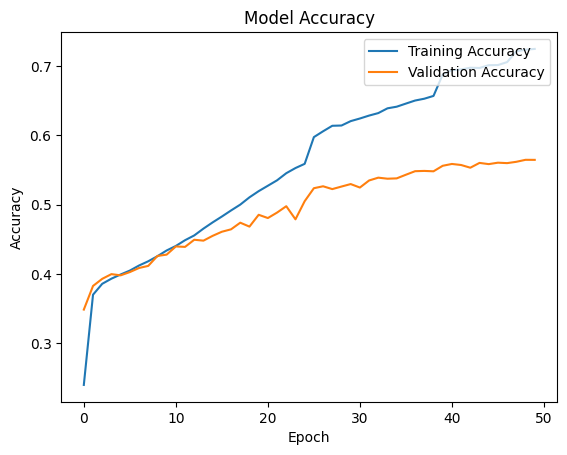

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.title('Model Accuracy')
plt.show()

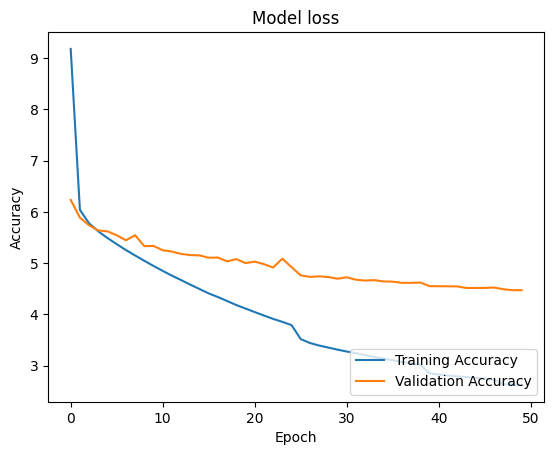

In [15]:
# Plot the training and validation accuracy
plt.plot(history.history['loss'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model loss')
plt.show()

In [17]:
def predict_code(description):
    # Convert description to sequence and pad it
    seq = tokenizer.texts_to_sequences([description])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    
    # Get prediction probabilities from the model
    pred = model.predict(padded)
    
    # Get predicted class index
    code_index = pred.argmax(axis=-1)[0]
    
    # Get the confidence (probability) of the predicted class
    confidence = pred[0][code_index]
    
    # Return the predicted code and its confidence score
    return encoder.inverse_transform([code_index])[0], confidence

# Example prediction with confidence
new_description = ""
predicted_code, confidence = predict_code(new_description)
print(f"The predicted code for the description '{new_description}' is: {predicted_code} with confidence: {confidence:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
The predicted code for the description '' is: Q000 with confidence: 0.2266


# 27-12-24


In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr=1e-7, max_lr=1e-2, num_iter=100):
        super().__init__()
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.num_iter = num_iter

        # Create an exponential decay learning rate scheduler
        self.lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_lr,
            decay_steps=num_iter,  # Decay steps should be set to num_iter
            decay_rate=(max_lr / initial_lr),  # Defines the range of learning rates
            staircase=False  # Avoids discrete jumps in learning rate
        )
        
        self.losses = []
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        # Update the learning rate using the exponential schedule
        lr = self.lr_schedule(batch)
        
        # Update the learning rate in the optimizer
        tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        
        # Record the loss and learning rate
        self.losses.append(logs['loss'])
        self.lrs.append(lr)

    def on_epoch_end(self, epoch, logs=None):
        # Plot the loss vs learning rate at the end of the epoch
        if epoch == 0:  # Plot after the first epoch
            plt.figure(figsize=(10, 6))
        plt.plot(self.lrs, self.losses, label="Loss vs Learning Rate")
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Learning Rate (log scale)")
        plt.ylabel("Loss (log scale)")
        plt.title("Learning Rate Finder")
        plt.grid(True)
        plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_lr_finder import LRFinder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

# Load the data and preprocess it (similar to your Keras code)

# Assume 'x_padded' and 'y_encoded' are ready from your Keras pipeline.
# Split into train and test sets
# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000  # Limit the vocabulary size
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))  # Set the max sequence length
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')




# Load pre-trained GloVe embeddings (Ensure you have the GloVe file loaded)
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings (adjust the file path to your GloVe file)
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt' # Change this path
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for PyTorch (You can fine-tune batch size as needed)
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Model definition in PyTorch (equivalent to your Keras model)

class YourModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, num_classes):
        super(YourModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        
        # Bidirectional GRU layer
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=512, num_layers=1, bidirectional=True, batch_first=True)
        
        # Attention layer
        self.attention = nn.MultiheadAttention(embed_dim=512 * 2, num_heads=8, batch_first=True)
        
        # Global Max Pooling layer (equivalent to Keras' GlobalMaxPooling1D)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        
        # Fully connected layer
        self.fc = nn.Linear(512 * 2, num_classes)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.gru(x)
        x, _ = self.attention(x, x, x)
        x = x.transpose(1, 2)
        x = self.pooling(x)
        x = x.squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Initialize the model
embedding_matrix = np.array(embedding_matrix)  # Assuming embedding_matrix is defined
model = YourModel(vocab_size=len(tokenizer.word_index) + 1, embedding_dim=300, embedding_matrix=embedding_matrix, num_classes=len(encoder.classes_))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Learning Rate Finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)

# Perform the learning rate range test
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)

# Plot the learning rate vs loss graph
lr_finder.plot()

# Reset the model and optimizer to their initial state
lr_finder.reset()


In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Attention, BatchNormalization, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000  # Limit the vocabulary size
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))  # Set the max sequence length
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings (Ensure you have the GloVe file loaded)
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings (adjust the file path to your GloVe file)
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt' # Change this path
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)

# Define the input layer explicitly
inputs = Input(shape=(x_train.shape[1],))  # x_train.shape[1] is the sequence length

# Embedding layer (using pre-trained embedding matrix)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,  
                            weights=[embedding_matrix], 
                            trainable=True)(inputs) 

# GRU layer with bidirectional
gru_output = Bidirectional(GRU(256, return_sequences=True, kernel_regularizer='l2'))(embedding_layer)

# Attention
attention_output = Attention()([gru_output, gru_output])
attention_output = BatchNormalization()(attention_output)

# Global max pooling
context = GlobalMaxPooling1D()(attention_output)
context = Dropout(0.4)(context) 

# Output layer
output = Dense(len(encoder.classes_), activation='softmax')(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile with different learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Model summary
model.summary()

# EarlyStopping and ReduceLROnPlateau for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 31, 300)   │  2,031,900 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 31, 512)   │    857,088 │ embedding_12[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_12        │ (None, 31, 512)   │          0 │ bidirectional_12… │
│ (Attention)         │                   │            │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 512)   │      2,048 │ attention_12[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 512)       │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 14583)     │  7,481,079 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,372,115 (39.57 MB)

 Trainable params: 10,371,091 (39.56 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.1570 - loss: 11.6161 - val_accuracy: 0.3699 - val_loss: 6.2484 - learning_rate: 1.0000e-04
Epoch 2/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3860 - loss: 5.6824 - val_accuracy: 0.4266 - val_loss: 5.1827 - learning_rate: 1.0000e-04
Epoch 3/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.4499 - loss: 4.5332 - val_accuracy: 0.4705 - val_loss: 4.6379 - learning_rate: 1.0000e-04
Epoch 4/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.5149 - loss: 3.6841 - val_accuracy: 0.5030 - val_loss: 4.3313 - learning_rate: 1.0000e-04
Epoch 5/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.5827 - loss: 2.9833 - val_accuracy: 0.5262 - val_loss: 4.1602 - learning_rate: 1.0000e-04
Epoch 6/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.6394 - loss: 2.4546 - val_accuracy: 0.5484 - val_loss: 4.0938 - learning_rate: 1.0000e-04
Epoch 7/100
1567/1567 ━━━━━━━━━━━

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 31, 300)   │  2,031,900 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_14    │ (None, 31, 512)   │    857,088 │ embedding_14[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_14        │ (None, 31, 512)   │          0 │ bidirectional_14… │
│ (Attention)         │                   │            │ bidirectional_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 512)   │      2,048 │ attention_14[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 512)       │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 14583)     │  7,481,079 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,372,115 (39.57 MB)

 Trainable params: 10,371,091 (39.56 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.3086 - loss: 7.4050 - val_accuracy: 0.3837 - val_loss: 5.4912
Epoch 2/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.4740 - loss: 4.4818 - val_accuracy: 0.4878 - val_loss: 4.6278
Epoch 3/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.5621 - loss: 3.2852 - val_accuracy: 0.5318 - val_loss: 4.3123
Epoch 4/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.6282 - loss: 2.5658 - val_accuracy: 0.5557 - val_loss: 4.3278
Epoch 5/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.6888 - loss: 2.1053 - val_accuracy: 0.5836 - val_loss: 4.3926
Epoch 6/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7425 - loss: 1.7675 - val_accuracy: 0.6006 - val_loss: 4.4096
Epoch 7/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7851 - loss: 1.5392 - val_accuracy: 0.6054 - val_loss: 4.6133
Epoch 8/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.8090 -

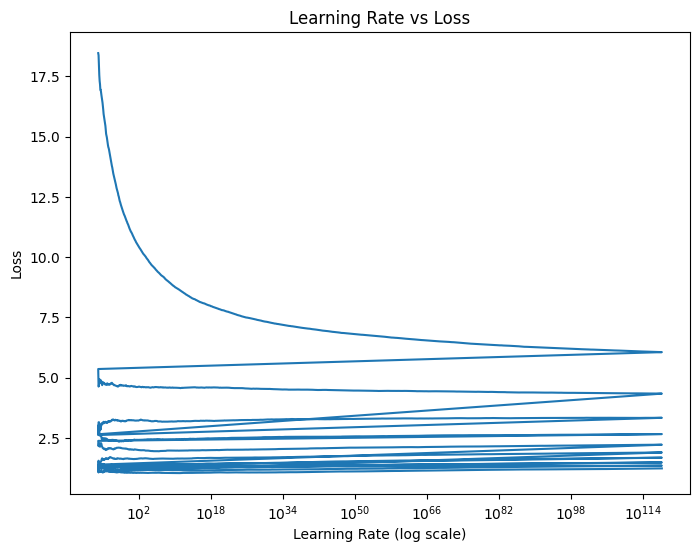

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Attention, BatchNormalization, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Model

# Define the Learning Rate Finder callback
class LRFinder(Callback):
    def __init__(self, start_lr, end_lr, num_iter, verbose=1):
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        self.verbose = verbose
        self.lr_values = []  # To store learning rate values
        self.losses = []     # To store loss values

    def on_batch_end(self, batch, logs=None):
        # Calculate the learning rate at this step
        lr = self.get_lr(batch)
        self.lr_values.append(lr)
        self.losses.append(logs['loss'])
    
    def get_lr(self, batch):
        # Exponentially scale the learning rate between start_lr and end_lr
        lr = self.start_lr * (self.end_lr / self.start_lr) ** (batch / self.num_iter)
        return lr

# Set the learning rate range
start_lr = 1e-7
end_lr = 10
num_iter = 100  # Number of steps (batches) to test over

# Define the input layer explicitly
inputs = Input(shape=(x_train.shape[1],))  # x_train.shape[1] is the sequence length

# Embedding layer (using pre-trained embedding matrix)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,  
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)

# GRU layer with bidirectional
gru_output = Bidirectional(GRU(256, return_sequences=True, kernel_regularizer='l2'))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])
attention_output = BatchNormalization()(attention_output)

# Global max pooling
context = GlobalMaxPooling1D()(attention_output)
context = Dropout(0.4)(context) 

# Output layer
output = Dense(len(encoder.classes_), activation='softmax')(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Model summary
model.summary()

# Initialize the LR Finder callback
lr_finder = LRFinder(start_lr=start_lr, end_lr=end_lr, num_iter=num_iter)

# Train the model with the LR Finder callback
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[lr_finder])

# Plot Learning Rate vs Loss
plt.figure(figsize=(8, 6))
plt.plot(lr_finder.lr_values, lr_finder.losses)
plt.xscale('log')  # Use log scale for the x-axis
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.show()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 31)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 31, 300)   │  2,031,900 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_20    │ (None, 31, 512)   │    857,088 │ embedding_20[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_20        │ (None, 31, 512)   │          0 │ bidirectional_20… │
│ (Attention)         │                   │            │ bidirectional_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 512)   │      2,048 │ attention_20[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 512)       │          0 │ global_max_pooli… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 14583)     │  7,481,079 │ dropout_20[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,372,115 (39.57 MB)

 Trainable params: 10,371,091 (39.56 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 30s 18ms/step - accuracy: 0.3035 - loss: 7.4296 - val_accuracy: 0.3360 - val_loss: 6.4982 - learning_rate: 0.0010
Epoch 2/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.4773 - loss: 4.4309 - val_accuracy: 0.4676 - val_loss: 5.0450 - learning_rate: 0.0010
Epoch 3/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.5637 - loss: 3.2549 - val_accuracy: 0.5179 - val_loss: 4.5587 - learning_rate: 0.0010
Epoch 4/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.6299 - loss: 2.5411 - val_accuracy: 0.5563 - val_loss: 4.3588 - learning_rate: 0.0010
Epoch 5/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.6872 - loss: 2.0760 - val_accuracy: 0.5770 - val_loss: 4.4918 - learning_rate: 0.0010
Epoch 6/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7397 - loss: 1.7529 - val_accuracy: 0.5886 - val_loss: 4.5793 - learning_rate: 0.0010
Epoch 7/10
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accura

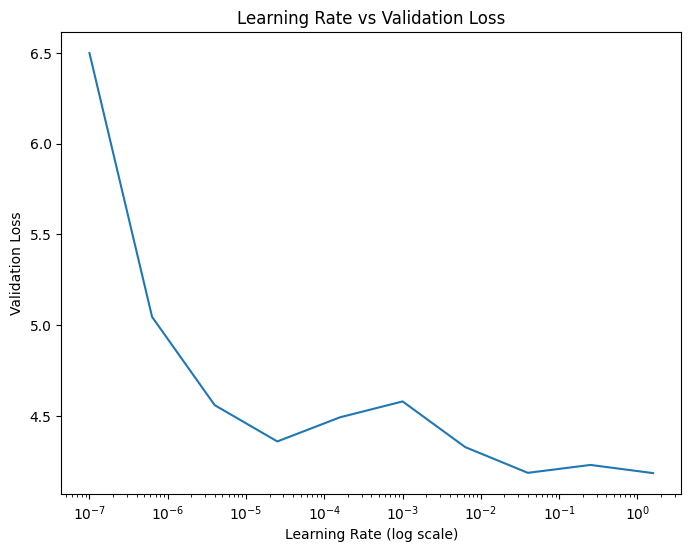

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Attention, BatchNormalization, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.models import Model

# Define the Learning Rate Finder callback
class LRFinder(Callback):
    def __init__(self, start_lr, end_lr, num_iter, verbose=1):
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iter = num_iter
        self.verbose = verbose
        self.lr_values = []  # To store learning rate values
        self.val_losses = []  # To store validation loss values

    def on_epoch_end(self, epoch, logs=None):
        # Log validation loss at the end of each epoch
        val_loss = logs.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss)
            # Update learning rate at the end of each epoch
            lr = self.get_lr(epoch)
            self.lr_values.append(lr)

    def get_lr(self, epoch):
        # Exponentially scale the learning rate between start_lr and end_lr
        lr = self.start_lr * (self.end_lr / self.start_lr) ** (epoch / self.num_iter)
        return lr

# Set the learning rate range
start_lr = 1e-7
end_lr = 10
num_iter = 10  # Number of steps (epochs) to test over

# Define the input layer explicitly
inputs = Input(shape=(x_train.shape[1],))  # x_train.shape[1] is the sequence length

# Embedding layer (using pre-trained embedding matrix)
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,  
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)

# GRU layer with bidirectional
gru_output = Bidirectional(GRU(256, return_sequences=True, kernel_regularizer='l2'))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])
attention_output = BatchNormalization()(attention_output)

# Global max pooling
context = GlobalMaxPooling1D()(attention_output)
context = Dropout(0.4)(context) 

# Output layer
output = Dense(len(encoder.classes_), activation='softmax')(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

# Model summary
model.summary()

# Initialize the LR Finder callback
lr_finder = LRFinder(start_lr=start_lr, end_lr=end_lr, num_iter=num_iter)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


# Train the model with the LR Finder callback
history = model.fit(x_train, y_train, epochs=num_iter, batch_size=32, validation_data=(x_test, y_test), callbacks=[lr_finder , lr_scheduler])

# Plot Learning Rate vs Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(lr_finder.lr_values, lr_finder.val_losses)
plt.xscale('log')  # Use log scale for the x-axis
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Loss')
plt.title('Learning Rate vs Validation Loss')
plt.show()


In [56]:
import keras_tuner as kt
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Attention, BatchNormalization, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Refactor model creation into a function that uses hyperparameters
def build_model(hp):
    inputs = tf.keras.Input(shape=(x_train.shape[1],))

    # Embedding layer (using pre-trained embedding matrix)
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                                output_dim=300,  # Fixed embedding dimension
                                weights=[embedding_matrix],
                                trainable=True)(inputs)

    # Hyperparameter tuning for the number of units in GRU
    gru_units = hp.Int('gru_units', min_value=128, max_value=1024, step=128)
    gru_output = Bidirectional(GRU(gru_units, return_sequences=True, activation='relu', kernel_regularizer='l2'))(embedding_layer)

    # Attention mechanism
    attention_output = Attention()([gru_output, gru_output])

    # BatchNormalization
    attention_output = BatchNormalization()(attention_output)

    # Global Max Pooling
    context = GlobalMaxPooling1D()(attention_output)

    # Dropout layer with hyperparameter tuning
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)
    context = Dropout(dropout_rate)(context)

    # Dense output layer (for classification)
    output = Dense(len(encoder.classes_), activation='softmax')(context)

    # Build the model
    model = tf.keras.Model(inputs=inputs, outputs=output)

    # Compile the model with a learning rate search space
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model


In [57]:
# Initialize the Keras Tuner with a RandomSearch (you can also try Hyperband or BayesianOptimization)
tuner = kt.RandomSearch(
    build_model, 
    objective='val_accuracy',  # Optimize validation accuracy
    max_trials=10,  # Number of hyperparameter configurations to try
    executions_per_trial=1,  # Number of executions per trial
    directory='my_dir',  # Directory to save tuner results
    project_name='model_tuning'
)

# Display search space summary
tuner.search_space_summary()

# Start the search (using the same training and validation data as before)
tuner.search(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=5)])


Trial 10 Complete [00h 04m 13s]
val_accuracy: 0.6251595616340637

Best val_accuracy So Far: 0.6638481020927429
Total elapsed time: 01h 17m 54s


In [ ]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
test_loss, test_acc = best_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


In [ ]:

# EarlyStopping and ReduceLROnPlateau for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = best_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

In [7]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Bidirectional, GlobalMaxPooling1D, Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt'
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)

# Define the model architecture
inputs = tf.keras.Input(shape=(x_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)

# First Bidirectional GRU layer
gru_output = Bidirectional(GRU(128, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])

# Batch Normalization
attention_output = BatchNormalization()(attention_output)

# Global Max Pooling to capture the strongest features
context = GlobalMaxPooling1D()(attention_output)

# Dropout for regularization
context = Dropout(0.5)(context)  # Increased dropout rate

# Dense output layer (for classification)
output = Dense(len(encoder.classes_), activation='softmax')(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Nadam optimizer
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# EarlyStopping and ReduceLROnPlateau for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
    

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 300)   │  1,903,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 22, 256)   │    330,240 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 22, 256)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 22, 256)   │      1,024 │ attention[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 14583)     │  3,747,831 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,982,295 (22.82 MB)

 Trainable params: 5,981,783 (22.82 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100


I0000 00:00:1735541492.140965      89 service.cc:145] XLA service 0x594495bc5a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735541492.141014      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 19/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0314 - loss: 15.1245     

I0000 00:00:1735541495.604302      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


784/784 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.2559 - loss: 8.0127 - val_accuracy: 0.4255 - val_loss: 5.0849 - learning_rate: 0.0010
Epoch 2/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.4476 - loss: 4.5185 - val_accuracy: 0.4867 - val_loss: 4.2127 - learning_rate: 0.0010
Epoch 3/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5297 - loss: 3.3502 - val_accuracy: 0.5323 - val_loss: 3.8052 - learning_rate: 0.0010
Epoch 4/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6006 - loss: 2.5891 - val_accuracy: 0.5580 - val_loss: 3.6612 - learning_rate: 0.0010
Epoch 5/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6495 - loss: 2.0925 - val_accuracy: 0.5901 - val_loss: 3.5869 - learning_rate: 0.0010
Epoch 6/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6988 - loss: 1.7655 - val_accuracy: 0.6049 - val_loss: 3.6299 - learning_rate: 0.0010
Epoch 7/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.7400 - loss: 1.5219

In [8]:
model.save('poc_model.h5')

# 30-12-24


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Load your CSV data
data = pd.read_csv('/kaggle/input/data-csv/diagnox.csv')

# Encode the labels
label_encoder = LabelEncoder()
data['code'] = label_encoder.fit_transform(data['code'])

# Text tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['description'])
sequences = tokenizer.texts_to_sequences(data['description'])
X = pad_sequences(sequences, maxlen=100)
y = data['code']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)

# Evaluate the model
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
print(f"Validation Accuracy: {val_accuracy[-1]}")
print(f"Validation Loss: {val_loss[-1]}")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.0679 - loss: 7.2873 - val_accuracy: 0.2314 - val_loss: 5.7859
Epoch 2/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.3251 - loss: 5.2008 - val_accuracy: 0.4121 - val_loss: 4.9898
Epoch 3/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4288 - loss: 4.1150 - val_accuracy: 0.4404 - val_loss: 4.7322
Epoch 4/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.4750 - loss: 3.3067 - val_accuracy: 0.4588 - val_loss: 4.5499
Epoch 5/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5242 - loss: 2.6663 - val_accuracy: 0.4807 - val_loss: 4.4577
Epoch 6/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.5951 - loss: 2.0776 - val_accuracy: 0.5011 - val_loss: 4.3908
Epoch 7/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.6646 - loss: 1.6497 - val_accuracy: 0.5278 - val_loss: 4.3484
Epoch 8/10
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.7317 - loss: 1.27

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load your CSV data
data = pd.read_csv('/kaggle/input/data-csv/diagnox.csv')

# Encode the labels
label_encoder = LabelEncoder()
data['code'] = label_encoder.fit_transform(data['code'])

# Text tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['description'])
sequences = tokenizer.texts_to_sequences(data['description'])
X = pad_sequences(sequences, maxlen=100)
y = data['code']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y)), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping, reduce_lr])

# Evaluate the model
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
print(f"Validation Accuracy: {val_accuracy[-1]}")
print(f"Validation Loss: {val_loss[-1]}")


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1568/1568 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.0629 - loss: 7.3928 - val_accuracy: 0.2404 - val_loss: 5.9124 - learning_rate: 0.0010
Epoch 2/20
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.2434 - loss: 5.5542 - val_accuracy: 0.3940 - val_loss: 5.4192 - learning_rate: 0.0010
Epoch 3/20
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.3867 - loss: 4.9574 - val_accuracy: 0.4106 - val_loss: 5.3193 - learning_rate: 0.0010
Epoch 4/20
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4078 - loss: 4.5894 - val_accuracy: 0.4147 - val_loss: 5.3326 - learning_rate: 0.0010
Epoch 5/20
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4092 - loss: 4.3358 - val_accuracy: 0.4247 - val_loss: 5.2666 - learning_rate: 0.0010
Epoch 6/20
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4243 - loss: 4.0251 - val_accuracy: 0.4329 - val_loss: 5.3031 - learning_rate: 0.0010
Epoch 7/20
1568/1568 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.4338 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 22, 300)   │  1,903,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 22, 128)   │    140,544 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 22, 128)   │          0 │ bidirectional_1[… │
│ (Attention)         │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ attention_1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 14583)     │  1,881,207 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,925,463 (14.97 MB)

 Trainable params: 3,925,207 (14.97 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100


I0000 00:00:1735551275.505439      90 service.cc:145] XLA service 0x7ca324001e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735551275.505492      90 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 21/784 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.0073 - loss: 15.8606      

I0000 00:00:1735551279.132687      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


784/784 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.1622 - loss: 9.1877 - val_accuracy: 0.3757 - val_loss: 5.9529 - learning_rate: 5.0000e-04
Epoch 2/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3665 - loss: 5.8968 - val_accuracy: 0.4069 - val_loss: 5.6547 - learning_rate: 5.0000e-04
Epoch 3/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3921 - loss: 5.5595 - val_accuracy: 0.4198 - val_loss: 5.5094 - learning_rate: 5.0000e-04
Epoch 4/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4091 - loss: 5.3424 - val_accuracy: 0.4330 - val_loss: 5.3850 - learning_rate: 5.0000e-04
Epoch 5/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4134 - loss: 5.2032 - val_accuracy: 0.4370 - val_loss: 5.3205 - learning_rate: 5.0000e-04
Epoch 6/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4311 - loss: 5.0259 - val_accuracy: 0.4533 - val_loss: 5.2653 - learning_rate: 5.0000e-04
Epoch 7/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4

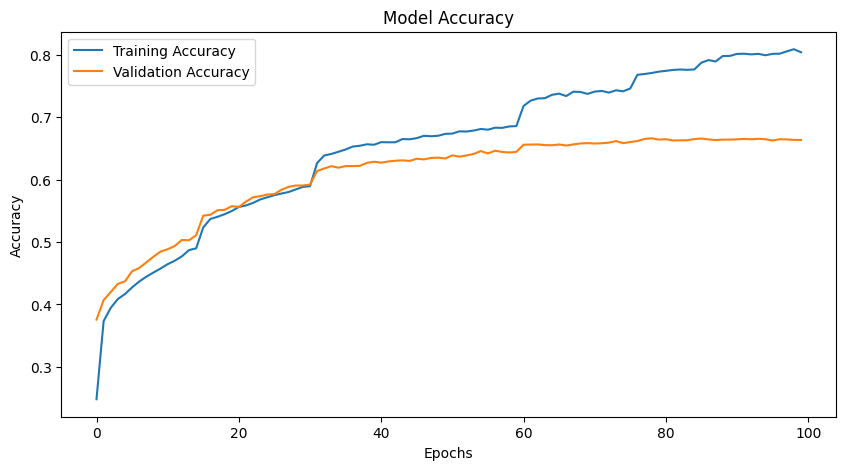

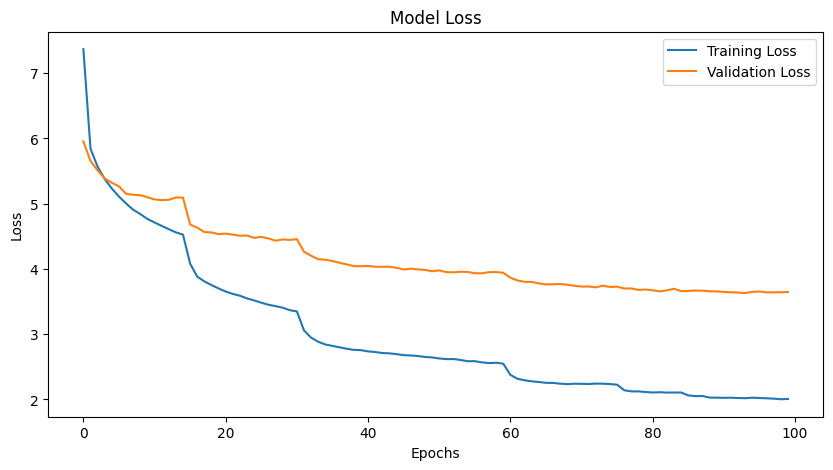

In [7]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Embedding, Bidirectional, GlobalMaxPooling1D, Attention, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Prepare features and labels
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt'
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)

# Define the model architecture
inputs = tf.keras.Input(shape=(x_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)

# First Bidirectional GRU layer
gru_output = Bidirectional(GRU(64, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])

# Batch Normalization
attention_output = BatchNormalization()(attention_output)

# Global Max Pooling to capture the strongest features
context = GlobalMaxPooling1D()(attention_output)

# Dropout for regularization
context = Dropout(0.6)(context)  # Increased dropout rate

# Dense output layer (for classification)
output = Dense(len(encoder.classes_), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer and reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# EarlyStopping, ReduceLROnPlateau, and ModelCheckpoint for better training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 22, 300)   │  1,903,200 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 22, 128)   │    140,544 │ embedding_6[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_6         │ (None, 22, 128)   │          0 │ bidirectional_6[… │
│ (Attention)         │                   │            │ bidirectional_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ attention_6[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 14583)     │  1,881,207 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,925,463 (14.97 MB)

 Trainable params: 3,925,207 (14.97 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.1611 - loss: 9.1941 - val_accuracy: 0.3852 - val_loss: 5.9350 - learning_rate: 5.0000e-04
Epoch 2/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3670 - loss: 5.8751 - val_accuracy: 0.4092 - val_loss: 5.6224 - learning_rate: 5.0000e-04
Epoch 3/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3917 - loss: 5.5441 - val_accuracy: 0.4213 - val_loss: 5.4634 - learning_rate: 5.0000e-04
Epoch 4/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4070 - loss: 5.3294 - val_accuracy: 0.4330 - val_loss: 5.3912 - learning_rate: 5.0000e-04
Epoch 5/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.4184 - loss: 5.1675 - val_accuracy: 0.4383 - val_loss: 5.3067 - learning_rate: 5.0000e-04
Epoch 6/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4253 - loss: 5.0578 - val_accuracy: 0.4513 - val_loss: 5.2479 - learning_rate: 5.0000e-04
Epoch 7/100
784/784 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - a

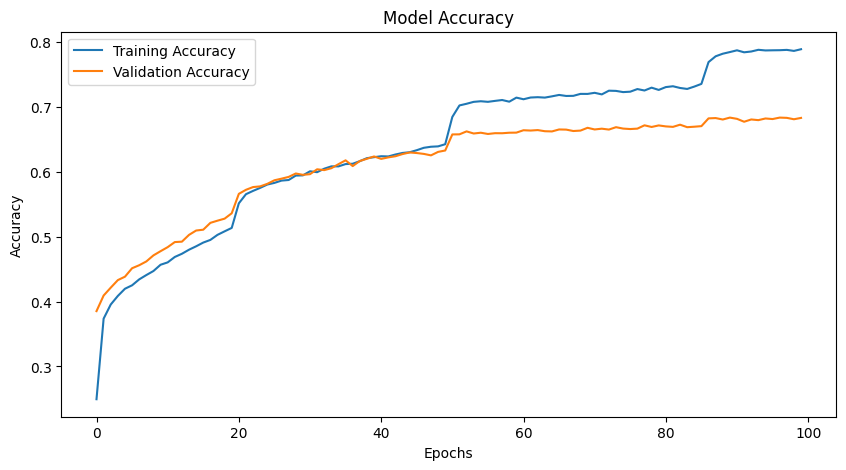

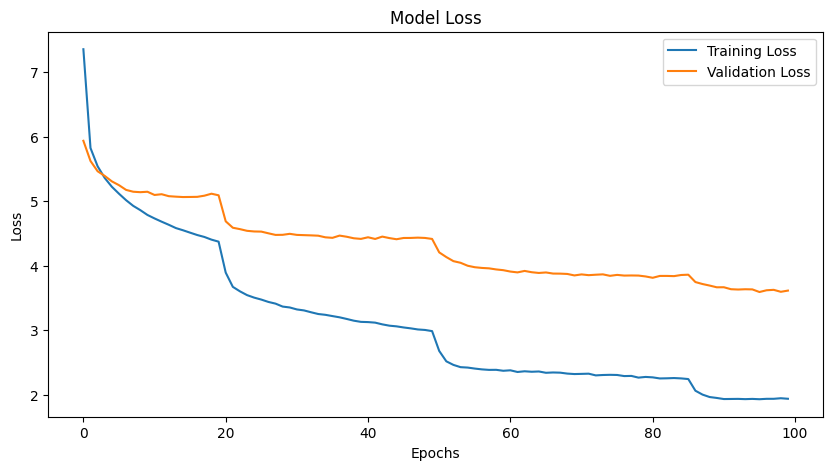

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, GRU, Embedding, Bidirectional, GlobalMaxPooling1D, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Assuming `data` is your dataset containing 'description' and 'code'
# Replace with your actual dataset loading logic
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt'
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)

# Define the model architecture
inputs = tf.keras.Input(shape=(x_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)

# First Bidirectional GRU layer
gru_output = Bidirectional(GRU(64, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])

# Batch Normalization
attention_output = BatchNormalization()(attention_output)

# Global Max Pooling to capture the strongest features
context = GlobalMaxPooling1D()(attention_output)

# Dropout for regularization
context = Dropout(0.6)(context)  # Increased dropout rate

# Dense output layer (for classification)
output = Dense(len(encoder.classes_), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer and reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
print(max_length)

22


In [43]:
def predict_code(description):
    # Convert description to sequence and pad it
    seq = tokenizer.texts_to_sequences([description])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    # Get prediction probabilities from the model
    pred = model.predict(padded)
    # Get predicted class index
    code_index = pred.argmax(axis=-1)[0]
    # Get the confidence (probability) of the predicted class
    confidence = pred[0][code_index]
    # Return the predicted code and its confidence score
    return encoder.inverse_transform([code_index])[0], confidence
 
# Example prediction with confidence
new_description = "Peripheral vascular disease without gangrene due to drug induced diabetes mellitus"
predicted_code, confidence = predict_code(new_description)
print(f"The predicted code for the description '{new_description}' is: {predicted_code} with confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
The predicted code for the description 'Peripheral vascular disease without gangrene due to drug induced diabetes mellitus' is: E0952 with confidence: 0.9066


In [45]:
model.save('final_poc.h5')

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten, GRU, Embedding, Bidirectional, GlobalMaxPooling1D, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

# Assuming `data` is your dataset containing 'description' and 'code'
# Replace with your actual dataset loading logic
x = data['description']
y = data['code']

# Label encoding for the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Tokenization and Padding
max_vocab_size = 10000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x)
max_length = max(len(seq) for seq in tokenizer.texts_to_sequences(x))
x_padded = pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length, padding='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_encoded, test_size=0.2, random_state=42)

# Load pre-trained GloVe embeddings
def load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embeddings_index:
            embedding_matrix[i] = embeddings_index[word]
    return embedding_matrix

# Load GloVe embeddings
glove_file_path = '/kaggle/input/glove1/glove.6B/glove.6B.300d.txt'
embedding_matrix = load_glove_embeddings(glove_file_path, tokenizer, embedding_dim=300)

# Define the model architecture
inputs = tf.keras.Input(shape=(x_train.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, 
                            output_dim=300,
                            weights=[embedding_matrix], 
                            trainable=True)(inputs)

# First Bidirectional GRU layer
gru_output = Bidirectional(GRU(64, return_sequences=True, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(embedding_layer)

# Attention mechanism
attention_output = Attention()([gru_output, gru_output])

# Batch Normalization
attention_output = BatchNormalization()(attention_output)

# Global Max Pooling to capture the strongest features
context = GlobalMaxPooling1D()(attention_output)

# Dropout for regularization
context = Dropout(0.6)(context)  # Increased dropout rate

# Dense output layer (for classification)
output = Dense(len(encoder.classes_), activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(context)

# Build the model
model = tf.keras.Model(inputs=inputs, outputs=output)

# Compile the model with Adam optimizer and reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
             loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 22)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 22, 300)   │  1,903,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 22, 128)   │    140,544 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 22, 128)   │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 22, 128)   │        512 │ attention[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 14583)     │  1,881,207 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,925,463 (14.97 MB)

 Trainable params: 3,925,207 (14.97 MB)

 Non-trainable params: 256 (1.00 KB)

In [9]:
from tensorflow.keras.models import load_model

def predict_code(description):
    # Convert description to sequence and pad it
    model = load_model("/kaggle/working/final_poc.h5")
    seq = tokenizer.texts_to_sequences([description])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    # Get prediction probabilities from the model
    pred = model.predict(padded)
    # Get predicted class index
    code_index = pred.argmax(axis=-1)[0]
    # Get the confidence (probability) of the predicted class
    confidence = pred[0][code_index]
    # Return the predicted code and its confidence score
    return encoder.inverse_transform([code_index])[0], confidence
 
# Example prediction with confidence
new_description = "Peripheral vascular disease without gangrene due to drug induced diabetes mellitus"
predicted_code, confidence = predict_code(new_description)
print(f"The predicted code for the description '{new_description}' is: {predicted_code} with confidence: {confidence:.4f}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/final_poc.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)